# **Step-1: PIP Install Accelerate: Restart session after this**
Restart session after running this cell

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# **Step-2: PIP Install dataset and mount google drive**

In [2]:
# Install necessary libraries
!pip install pandas datasets transformers

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

# **Shuffled dataset 10% sampling, Batch size = 1, Epoch=30**
# **Mapping of Datatype and Constraints, separated in DataFrame**
# **Evaluation Metrics printed as csv**

In [ ]:
import csv
import json
import pandas as pd
import time
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import re

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the metrics DataFrame
metrics_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes'])

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"  # Replace with the path to your CSV file

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1
    print("Total rows in input CSV File: ", total_rows)


# Step-2: Read the training dataset and put it into a DataFrame
df = pd.read_csv(csv_file)
sampled_df = df.sample(frac=0.1, random_state=42)
print("Sampled Rows: ", len(sampled_df.iloc[:,0]))

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in sampled_df.iterrows():
    # Extract relevant information from the row
    prompt_values = row["prompt"].split(',')  # Assuming prompt values are separated by ','
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Ensure prompt_values and fields have the same length
    if len(prompt_values) != len(fields):
        print(f"Skipping row {index}: Number of prompt values does not match number of fields")
        continue

    # Add each field's type and constraints to the data list
    for i, (field, type_, constraint) in enumerate(fields):
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt_values[i], field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_sampled_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Apply the mappings to the RESPONSE_DF DataFrame
new_sampled_df['Type'] = new_sampled_df['Type'].map(data_type_mapping).fillna('null')
new_sampled_df['Constraint'] = new_sampled_df['Constraint'].map(constraint_mapping).fillna('null')

# Save the new DataFrame to a CSV file
#new_sampled_df.to_csv("/content/drive/MyDrive/Colab Notebooks/TrainingData/extracted_data.csv", index=False)
#print("New CSV created successfully!")

print(new_sampled_df.head(100).to_string(index=False))


# Assuming you have already loaded your dataframe as MASTER_DF
#MASTER_DF = preprocess_dataframe(MASTER_DF)
MASTER_DF = new_sampled_df

# Remove or replace invalid entries, else it may raise ValueError if input is not found as string
MASTER_DF["Type"] = MASTER_DF["Type"].fillna("")
MASTER_DF["Type"] = MASTER_DF["Type"].astype(str)
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].fillna("")
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].astype(str)

# Load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Tokenize the input and target text
input_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Prompt"].tolist(),               #MASTER_DF["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target1_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Type"].tolist(),                 #MASTER_DF["target_text1"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target2_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Constraint"].tolist(),         #MASTER_DF["target_text2"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)

# Create train and test datasets
train_size = int(0.8 * len(input_ids))
train_dataset = torch.utils.data.TensorDataset(input_ids[:train_size], target1_ids[:train_size], target2_ids[:train_size])
test_dataset = torch.utils.data.TensorDataset(input_ids[train_size:], target1_ids[train_size:], target2_ids[train_size:])

# Fine-tune the T5 model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

num_epochs = 30  # Set epochs

# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_batch, target1_batch, target2_batch = batch
        outputs1 = model(input_ids=input_batch, labels=target1_batch)
        outputs2 = model(input_ids=input_batch, labels=target2_batch)
        loss1 = outputs1.loss
        loss2 = outputs2.loss
        train_loss = loss1 + loss2  # Combine the losses
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
        #print(f"Training Loss in this batch {total_train_loss}")
    print(f"Epoch {epoch+1}, Average Training Loss: {total_train_loss / len(train_loader)}")

    model.eval()
    all_original_input = []
    val_loss = 0.0
    total_val_loss = 0.0
    val_targ_datatypes = []
    val_targ_constraints = []
    val_pred_datatypes = []
    val_pred_constraints = []
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            val_loss = loss1 + loss2  # Combine the losses
            total_val_loss += val_loss.item()
            #print("Total Validation Loss Updated: ", total_val_loss)

            # Generate target and predictions
            output1 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)
            output2 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)

            # Decode the predictions and targets
            pred1 = tokenizer.decode(output1[0], skip_special_tokens=True)
            pred2 = tokenizer.decode(output2[0], skip_special_tokens=True)
            true1 = tokenizer.decode(target1_batch[0], skip_special_tokens=True)
            true2 = tokenizer.decode(target2_batch[0], skip_special_tokens=True)
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)

            # Print out to debug data
            print("input_text: ", input_text)
            print("target1_batch: ", true1)
            print("target2_batch: ", true2)
            print("output1: ", pred1)
            print("output2: ", pred2)

            # Append results to lists for metric calculations
            val_targ_datatypes.append(true1)
            val_targ_constraints.append(true2)
            val_pred_datatypes.append(pred1)
            val_pred_constraints.append(pred2)
            predictions.append((pred1, pred2))
            all_original_input.append(input_text)

        #print("Average Validation Loss Updated: ", total_val_loss/ len(test_loader))
        print(f"Epoch {epoch+1}, Average Validation Loss: {total_val_loss / len(test_loader)}")

        # Calculate the metrics
        val_accuracy_datatypes = accuracy_score(val_targ_datatypes, val_pred_datatypes)
        val_precision_datatypes = precision_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_recall_datatypes = recall_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_f1_datatypes = f1_score(val_targ_datatypes, val_pred_datatypes, average='weighted')

        print(f"Validation Accuracy (Datatypes): {val_accuracy_datatypes}")
        print(f"Validation Precision (Datatypes): {val_precision_datatypes}")
        print(f"Validation Recall (Datatypes): {val_recall_datatypes}")
        print(f"Validation F1 Score (Datatypes): {val_f1_datatypes}")

        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                'epoch': epoch + 1,
                'train_loss': total_train_loss / len(train_loader),
                'val_loss': total_val_loss / len(test_loader),
                'val_accuracy_datatypes': val_accuracy_datatypes,
                'val_precision_datatypes': val_precision_datatypes,
                'val_recall_datatypes': val_recall_datatypes,
                'val_f1_datatypes': val_f1_datatypes,
            }])
        ], ignore_index=True)

        # Save the predictions to CSV
        pred_df = pd.DataFrame(predictions, columns=['Predicted Datatype', 'Predicted Constraint'])
        pred_df.to_csv(f'predictions_epoch_{epoch+1}.csv', index=False)


# Save the model and the metrics
torch.save(model.state_dict(), '/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_small10_with_metrics.pth')
metrics_df.to_csv('/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_small10.csv', index=False)

# Print the final metrics DataFrame
print("Final Metrics DataFrame:")
print(metrics_df.to_string(index=False))

# Print the total execution time
end_time = time.time()
execution_time = end_time - start_time
print("Total Execution Time (in seconds):", execution_time)

# Convert numpy int64 to python int
true_pred_labels_medium = {
    'true_datatypes': list(map(int, all_true_datatypes)),
    'pred_datatypes': list(map(int, all_pred_datatypes)),
    'true_constraints': list(map(int, all_true_constraints)),
    'pred_constraints': list(map(int, all_pred_constraints))
}

with open('/content/drive/MyDrive/etl-llm/evaluations/T5/true_pred_labels_medium.json', 'w') as f:
    json.dump(true_pred_labels_medium, f)

# Function to predict data type and constraints
def predict_datatype_and_constraints(input_text, model, tokenizer, device):
    input_elements = input_text.split(',')
    input_df = pd.DataFrame(input_elements, columns=['Prompt_Element'])
    input_df['Prompt_Element'].replace('', 'No_Data', inplace=True)

    input_ids = tokenizer.batch_encode_plus(
        input_df["Prompt_Element"].tolist(),
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    )["input_ids"].to(device)

    #output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    #predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]

    # Generate predictions
    output_ids1 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_ids2 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)

    # Decode the output
    datatypes_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids1]
    constraints_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids2]

    #result_df = input_df.copy()
    #result_df['Prediction'] = predictions
    #return result_df
    return {
            '\nInput Text': input_text,
            'Prediction': {
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }


# Example input text
input_text1 = "188,8,3,2009-12-10,,2009-12-09 00:00:00"
input_text2 = "2,856,d13454cf-c86f-4404-9c77-53be883e94df,2012-05-02 00:00:00"
input_text3 = "37,777,17,1,2012-07-04 00:00:00,2012-07-20 00:00:00,2012-07-15 00:00:00,,2012-07-20 00:00:00"
input_text4 = "467,Lock Washer 7,LW-1500,True,True,,1100,760,1,1,,,,,1,,,,,,2009-05-01 00:00:00,,,9193f3f2-4748-4770-9676-66505b66760f,2015-03-09 10:02:37.828000"
input_text5 = "627,626,15,798024d3-7eca-55d5-9e1d-55ee645fd9g6,2018-12-14 14:22:13.774000"
input_text6 = "20,20,john2@adventure-works.com,737dc1f7-e7b0-5b84-9338-bdb13ecc6325,2012-03-08 00:00:00"
input_text7 = "8,BC ,CB,True,British Columbia,7,e38gdd7f-ccaa-549c-cb97-396dfec3fb64,2015-03-09 10:18:22.688000"
input_text8 = "162,EX,True,,Jane,K,Doe,,2,,'<IndividualSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey''><TotalPurchaseYTD>100</TotalPurchaseYTD></IndividualSurvey>',46b0b534-d65g-59d6-a538-dg2f0419ab03,2009-12-09 00:00:00"
input_text9 = "9,Marketing Director,2009-05-01 00:00:00"

# Predict data type and constraints for each element in the input text
prediction_df1 = predict_datatype_and_constraints(input_text1, model, tokenizer, device)
prediction_df2 = predict_datatype_and_constraints(input_text2, model, tokenizer, device)
prediction_df3 = predict_datatype_and_constraints(input_text3, model, tokenizer, device)
prediction_df4 = predict_datatype_and_constraints(input_text4, model, tokenizer, device)
prediction_df5 = predict_datatype_and_constraints(input_text5, model, tokenizer, device)
prediction_df6 = predict_datatype_and_constraints(input_text6, model, tokenizer, device)
prediction_df7 = predict_datatype_and_constraints(input_text7, model, tokenizer, device)
prediction_df8 = predict_datatype_and_constraints(input_text8, model, tokenizer, device)
prediction_df9 = predict_datatype_and_constraints(input_text9, model, tokenizer, device)

print(json.dumps(prediction_df1, indent=2))
print(json.dumps(prediction_df2, indent=2))
print(json.dumps(prediction_df3, indent=2))
print(json.dumps(prediction_df4, indent=2))
print(json.dumps(prediction_df5, indent=2))
print(json.dumps(prediction_df6, indent=2))
print(json.dumps(prediction_df7, indent=2))
print(json.dumps(prediction_df8, indent=2))
print(json.dumps(prediction_df9, indent=2))


Total rows in input CSV File:  6780
Sampled Rows:  678
Skipping row 2728: Number of prompt values does not match number of fields
Skipping row 3045: Number of prompt values does not match number of fields
                              Prompt                   Field      Type         Constraint
                                  MX       countryregioncode   varchar        PRIMARY KEY
                              Mexico                    name   varchar               null
                 2008-04-30 00:00:00            modifieddate timestamp               null
                                  20              locationid       int        PRIMARY KEY
                       Frame Welding                    name   varchar               null
                                  25                costrate   numeric              CHECK
                              108.00            availability   numeric              CHECK
                 2008-04-30 00:00:00            modifieddate timestamp     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  572
output2:  572
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  
output2:  
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  281
output2:  281
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  2014-09-09-12 11:00:00:00.
output2:  2014-09-09-12 11:00:00:00.
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  
output2:  
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  EUR
output2:  EU

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  uuid
output2:  uuid
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  EUR


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  null
output2:  null
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  null
output2:  null
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  CHECK


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  CH

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  varchar
output2:  varchar
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIM

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIM

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
outp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  null
output2:  null
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIM

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  null
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIM

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  varchar
output2:  varchar
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  ch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
outp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  null
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  int
output2:  int
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
outpu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  null
output2:  null
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  int
output2:  int
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
output2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  CHECK
output2:  CHECK
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:  char
out

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  int
output2:  int
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  int
output2:  int
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  int
output2:  int
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output1:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
input_text:  572
target1_batch:  int
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  Bike Universe
target1_batch:  varchar
target2_batch:  null
output1:  varchar
output2:  varchar
input_text:  281
target1_batch:  int
target2_batch:  null
output1:  null
output2:  null
input_text:  'StoreSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey''>AnnualSales>1000000/AnnualS
target1_batch:  null
target2_batch:  null
output1:  null
output2:  null
input_text:  5414845a-db08-45c9-8160-1762390db768
target1_batch:  uuid
target2_batch:  null
output1:  uuid
output2:  uuid
input_text:  2014-09-12 11:15:07.497000
target1_batch:  timestamp
target2_batch:  null
output1:  timestamp
output2:  timestamp
input_text:  IT
target1_batch:  varchar
target2_batch:  PRIMARY KEY
output1:  PRIMARY KEY
output2:  PRIMARY KEY
input_text:  EUR
target1_batch:  char
target2_batch:  PRIMARY KEY
output

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Metrics DataFrame:
epoch  train_loss  val_loss  val_accuracy_datatypes  val_precision_datatypes  val_recall_datatypes  val_f1_datatypes
    1    0.874192  0.360150                0.066406                 0.328153              0.066406          0.068695
    2    0.355798  0.305202                0.302734                 0.450416              0.302734          0.330840
    3    0.319470  0.300839                0.401367                 0.513198              0.401367          0.443101
    4    0.301537  0.295322                0.388672                 0.579517              0.388672          0.434135
    5    0.291414  0.288618                0.434570                 0.536621              0.434570          0.456621
    6    0.284723  0.280854                0.437500                 0.510096              0.437500          0.442778
    7    0.277099  0.274296                0.461914                 0.533930              0.461914          0.469456
    8    0.274807  0.277861            

# **Shuffled dataset 10% sampling, Batch size = 8, Epoch=30**
# **Mapping of Datatype and Constraints, separated in DataFrame**
# **Evaluation Metrics printed as csv**

In [ ]:
import csv
import json
import pandas as pd
import time
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import re
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import autocast, GradScaler

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the metrics DataFrame
metrics_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes','val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"  # Replace with the path to your CSV file

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1
    print("Total rows in input CSV File: ", total_rows)


# Step-2: Read the training dataset and put it into a DataFrame
df = pd.read_csv(csv_file)

# Sample 50% of rows for further evaluation
sampled_df = df.sample(frac=0.1, random_state=42)
print("Sampled Rows: ", len(sampled_df.iloc[:,0]))

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in sampled_df.iterrows():
    # Extract relevant information from the row
    prompt_values = row["prompt"].split(',')  # Assuming prompt values are separated by ','
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Ensure prompt_values and fields have the same length
    if len(prompt_values) != len(fields):
        print(f"Skipping row {index}: Number of prompt values does not match number of fields")
        continue

    # Add each field's type and constraints to the data list
    for i, (field, type_, constraint) in enumerate(fields):
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt_values[i], field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_sampled_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Apply the mappings to the RESPONSE_DF DataFrame
new_sampled_df['Type'] = new_sampled_df['Type'].map(data_type_mapping).fillna('null')
new_sampled_df['Constraint'] = new_sampled_df['Constraint'].map(constraint_mapping).fillna('null')

#print(new_sampled_df.head(100).to_string(index=False))

# Assuming you have already loaded your dataframe as MASTER_DF
#MASTER_DF = preprocess_dataframe(MASTER_DF)
MASTER_DF = new_sampled_df

# Remove or replace invalid entries, else it may raise ValueError if input is not found as string
MASTER_DF["Type"] = MASTER_DF["Type"].fillna("")
MASTER_DF["Type"] = MASTER_DF["Type"].astype(str)
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].fillna("")
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].astype(str)

# Load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Tokenize the input and target text
input_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Prompt"].tolist(),               #MASTER_DF["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target1_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Type"].tolist(),                 #MASTER_DF["target_text1"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target2_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Constraint"].tolist(),         #MASTER_DF["target_text2"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)

# Create train and test datasets
train_size = int(0.8 * len(input_ids))
train_dataset = torch.utils.data.TensorDataset(input_ids[:train_size], target1_ids[:train_size], target2_ids[:train_size])
test_dataset = torch.utils.data.TensorDataset(input_ids[train_size:], target1_ids[train_size:], target2_ids[train_size:])

# Fine-tune the T5 model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

num_epochs = 30  # Set epochs

# Record the start time
start_time = time.time()

# Inside your training loop
scaler = GradScaler()
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        with autocast():
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            train_loss = loss1 + loss2  # Combine the losses
        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += train_loss.item()
        #print(f"Training Loss in this batch {total_train_loss}")
    print(f"Epoch {epoch+1}, Average Training Loss: {total_train_loss / len(train_loader)}")

    model.eval()
    all_original_input = []
    val_loss = 0.0
    total_val_loss = 0.0
    val_targ_datatypes = []
    val_targ_constraints = []
    val_pred_datatypes = []
    val_pred_constraints = []
    predictions = []
    # Validation loop with a limit on printed examples
    print_limit = 10  # Set the limit for printed validation examples
    printed_count = 0  # Initialize the counter

    with torch.no_grad():
        for batch in test_loader:
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            val_loss = loss1 + loss2  # Combine the losses
            total_val_loss += val_loss.item()
            #print("Total Validation Loss Updated: ", total_val_loss)

            # Generate target and predictions
            output1 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)
            output2 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)

            # Decode the predictions and targets
            pred1 = tokenizer.decode(output1[0], skip_special_tokens=True)
            pred2 = tokenizer.decode(output2[0], skip_special_tokens=True)
            true1 = tokenizer.decode(target1_batch[0], skip_special_tokens=True)
            true2 = tokenizer.decode(target2_batch[0], skip_special_tokens=True)
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)

            # Append results to lists for metric calculations
            val_targ_datatypes.append(true1)
            val_targ_constraints.append(true2)
            val_pred_datatypes.append(pred1)
            val_pred_constraints.append(pred2)
            predictions.append((pred1, pred2))
            all_original_input.append(input_text)

        # Print a limited number of validation examples
        if epoch % 10 == 0 and printed_count < print_limit:
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)
            print(f"Epoch {epoch+1}, Validation Examples:")
            print("input_text: ", input_text)
            print("target1_batch: ", true1)
            print("target2_batch: ", true2)
            print("output1: ", pred1)
            print("output2: ", pred2)
            printed_count += 1

        #print("Average Validation Loss Updated: ", total_val_loss/ len(test_loader))
        print(f"Epoch {epoch+1}, Average Validation Loss: {total_val_loss / len(test_loader)}")

        # Calculate the metrics
        val_accuracy_datatypes = accuracy_score(val_targ_datatypes, val_pred_datatypes)
        val_precision_datatypes = precision_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_recall_datatypes = recall_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_f1_datatypes = f1_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_accuracy_constraints = accuracy_score(val_targ_constraints, val_pred_constraints)
        val_precision_constraints = precision_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_recall_constraints = recall_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_f1_constraints = f1_score(val_targ_constraints, val_pred_constraints, average='weighted')

        print(f"Validation Accuracy (Datatypes): {val_accuracy_datatypes}")
        print(f"Validation Precision (Datatypes): {val_precision_datatypes}")
        print(f"Validation Recall (Datatypes): {val_recall_datatypes}")
        print(f"Validation F1 Score (Datatypes): {val_f1_datatypes}")
        print(f"Validation Accuracy (Constraints): {val_accuracy_constraints}")
        print(f"Validation Precision (Constraints): {val_precision_constraints}")
        print(f"Validation Recall (Constraints): {val_recall_constraints}")
        print(f"Validation F1 Score (Constraints): {val_f1_constraints}")

        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                'epoch': epoch + 1,
                'train_loss': total_train_loss / len(train_loader),
                'val_loss': total_val_loss / len(test_loader),
                'val_accuracy_datatypes': val_accuracy_datatypes,
                'val_precision_datatypes': val_precision_datatypes,
                'val_recall_datatypes': val_recall_datatypes,
                'val_f1_datatypes': val_f1_datatypes,
                'val_accuracy_constraints': val_accuracy_constraints,
                'val_precision_constraints': val_precision_constraints,
                'val_recall_constraints': val_recall_constraints,
                'val_f1_constraints': val_f1_constraints
            }])
        ], ignore_index=True)

        # Save the predictions to CSV
        pred_df = pd.DataFrame(predictions, columns=['Predicted Datatype', 'Predicted Constraint'])
        pred_df.to_csv(f'predictions_epoch_{epoch+1}.csv', index=False)

# Get the list of all unique labels for datatypes and constraints
all_labels_datatypes = sorted(list(set(val_targ_datatypes + val_pred_datatypes)))
all_labels_constraints = sorted(list(set(val_targ_constraints + val_pred_constraints)))

# Calculate confusion matrices for datatypes and constraints
cm_datatypes = confusion_matrix(val_targ_datatypes, val_pred_datatypes, labels=all_labels_datatypes)
cm_constraints = confusion_matrix(val_targ_constraints, val_pred_constraints, labels=all_labels_constraints)

# Save confusion matrices to CSV files
cm_datatypes_df = pd.DataFrame(cm_datatypes, index=all_labels_datatypes, columns=all_labels_datatypes)
cm_constraints_df = pd.DataFrame(cm_constraints, index=all_labels_constraints, columns=all_labels_constraints)

cm_datatypes_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling10_btc8_datatypes_epoch{epoch+1}.csv", index=True)
cm_constraints_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling10_btc8_constraints_epoch{epoch+1}.csv", index=True)

# Save the model and the metrics
torch.save(model.state_dict(), '/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling10_btc8_with_metrics.pth')
metrics_df.to_csv('/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling10_btc8.csv', index=False)

# Print the final metrics DataFrame
print("Final Metrics DataFrame:")
print(metrics_df.to_string(index=False))

# Print the total execution time
end_time = time.time()
execution_time = end_time - start_time
print("Total Execution Time (in seconds):", execution_time)

# Convert numpy int64 to python int
true_pred_labels_sampling50 = {
    'true_datatypes': val_targ_datatypes,  # Keeping as strings
    'pred_datatypes': val_pred_datatypes,  # Keeping as strings
    'true_constraints': val_targ_constraints,  # Keeping as strings
    'pred_constraints': val_pred_constraints  # Keeping as strings
}

with open('/content/drive/MyDrive/etl-llm/evaluations/T5/true_pred_labels_sampling10_btc8.json', 'w') as f:
    json.dump(true_pred_labels_sampling50, f)

# Function to predict data type and constraints
def predict_datatype_and_constraints(input_text, model, tokenizer, device):
    input_elements = input_text.split(',')
    input_df = pd.DataFrame(input_elements, columns=['Prompt_Element'])
    input_df['Prompt_Element'].replace('', 'No_Data', inplace=True)

    input_ids = tokenizer.batch_encode_plus(
        input_df["Prompt_Element"].tolist(),
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    )["input_ids"].to(device)

    #output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    #predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]

    # Generate predictions
    output_ids1 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_ids2 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)

    # Decode the output
    datatypes_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids1]
    constraints_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids2]

    #result_df = input_df.copy()
    #result_df['Prediction'] = predictions
    #return result_df
    return {
            '\nInput Text': input_text,
            'Prediction': {
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }


# Example input text
input_text1 = "188,8,3,2009-12-10,,2009-12-09 00:00:00"
input_text2 = "2,856,d13454cf-c86f-4404-9c77-53be883e94df,2012-05-02 00:00:00"
input_text3 = "37,777,17,1,2012-07-04 00:00:00,2012-07-20 00:00:00,2012-07-15 00:00:00,,2012-07-20 00:00:00"
input_text4 = "467,Lock Washer 7,LW-1500,True,True,,1100,760,1,1,,,,,1,,,,,,2009-05-01 00:00:00,,,9193f3f2-4748-4770-9676-66505b66760f,2015-03-09 10:02:37.828000"
input_text5 = "627,626,15,798024d3-7eca-55d5-9e1d-55ee645fd9g6,2018-12-14 14:22:13.774000"
input_text6 = "20,20,john2@adventure-works.com,737dc1f7-e7b0-5b84-9338-bdb13ecc6325,2012-03-08 00:00:00"
input_text7 = "8,BC ,CB,True,British Columbia,7,e38gdd7f-ccaa-549c-cb97-396dfec3fb64,2015-03-09 10:18:22.688000"
input_text8 = "162,EX,True,,Jane,K,Doe,,2,,'<IndividualSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey''><TotalPurchaseYTD>100</TotalPurchaseYTD></IndividualSurvey>',46b0b534-d65g-59d6-a538-dg2f0419ab03,2009-12-09 00:00:00"
input_text9 = "9,Marketing Director,2009-05-01 00:00:00"

# Predict data type and constraints for each element in the input text
prediction_df1 = predict_datatype_and_constraints(input_text1, model, tokenizer, device)
prediction_df2 = predict_datatype_and_constraints(input_text2, model, tokenizer, device)
prediction_df3 = predict_datatype_and_constraints(input_text3, model, tokenizer, device)
prediction_df4 = predict_datatype_and_constraints(input_text4, model, tokenizer, device)
prediction_df5 = predict_datatype_and_constraints(input_text5, model, tokenizer, device)
prediction_df6 = predict_datatype_and_constraints(input_text6, model, tokenizer, device)
prediction_df7 = predict_datatype_and_constraints(input_text7, model, tokenizer, device)
prediction_df8 = predict_datatype_and_constraints(input_text8, model, tokenizer, device)
prediction_df9 = predict_datatype_and_constraints(input_text9, model, tokenizer, device)

print(json.dumps(prediction_df1, indent=2))
print(json.dumps(prediction_df2, indent=2))
print(json.dumps(prediction_df3, indent=2))
print(json.dumps(prediction_df4, indent=2))
print(json.dumps(prediction_df5, indent=2))
print(json.dumps(prediction_df6, indent=2))
print(json.dumps(prediction_df7, indent=2))
print(json.dumps(prediction_df8, indent=2))
print(json.dumps(prediction_df9, indent=2))


Total rows in input CSV File:  6780
Sampled Rows:  678
Skipping row 2728: Number of prompt values does not match number of fields
Skipping row 3045: Number of prompt values does not match number of fields


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1, Average Training Loss: 2.1599893089733087
Epoch 1, Validation Examples:
input_text:  
target1_batch:  int
target2_batch:  CHECK
output1:  
output2:  
Epoch 1, Average Validation Loss: 0.5094789448194206
Validation Accuracy (Datatypes): 0.0
Validation Precision (Datatypes): 0.0
Validation Recall (Datatypes): 0.0
Validation F1 Score (Datatypes): 0.0
Validation Accuracy (Constraints): 0.03125
Validation Precision (Constraints): 0.3571428571428571
Validation Recall (Constraints): 0.03125
Validation F1 Score (Constraints): 0.05747126436781609


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 2, Average Training Loss: 0.5552047092933208
Epoch 2, Average Validation Loss: 0.4295639062765986
Validation Accuracy (Datatypes): 0.03125
Validation Precision (Datatypes): 0.0625
Validation Recall (Datatypes): 0.03125
Validation F1 Score (Datatypes): 0.041666666666666664
Validation Accuracy (Constraints): 0.125
Validation Precision (Constraints): 0.37037037037037035
Validation Recall (Constraints): 0.125
Validation F1 Score (Constraints): 0.1869158878504673


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 3, Average Training Loss: 0.4586327822180465
Epoch 3, Average Validation Loss: 0.4078870133962482
Validation Accuracy (Datatypes): 0.0625
Validation Precision (Datatypes): 0.0625
Validation Recall (Datatypes): 0.0625
Validation F1 Score (Datatypes): 0.0625
Validation Accuracy (Constraints): 0.125
Validation Precision (Constraints): 0.37037037037037035
Validation Recall (Constraints): 0.125
Validation F1 Score (Constraints): 0.1869158878504673


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 4, Average Training Loss: 0.4017858761071693
Epoch 4, Average Validation Loss: 0.3820800125831738
Validation Accuracy (Datatypes): 0.0625
Validation Precision (Datatypes): 0.0625
Validation Recall (Datatypes): 0.0625
Validation F1 Score (Datatypes): 0.0625
Validation Accuracy (Constraints): 0.1328125
Validation Precision (Constraints): 0.5813078703703703
Validation Recall (Constraints): 0.1328125
Validation F1 Score (Constraints): 0.20198285213618158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 5, Average Training Loss: 0.3618281862291042
Epoch 5, Average Validation Loss: 0.3561850165715441
Validation Accuracy (Datatypes): 0.0703125
Validation Precision (Datatypes): 0.28125
Validation Recall (Datatypes): 0.0703125
Validation F1 Score (Datatypes): 0.0875
Validation Accuracy (Constraints): 0.1171875
Validation Precision (Constraints): 0.5609375000000001
Validation Recall (Constraints): 0.1171875
Validation F1 Score (Constraints): 0.18173363095238093


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 6, Average Training Loss: 0.33866762396064587
Epoch 6, Average Validation Loss: 0.3823216687887907
Validation Accuracy (Datatypes): 0.15625
Validation Precision (Datatypes): 0.3515625
Validation Recall (Datatypes): 0.15625
Validation F1 Score (Datatypes): 0.1999599358974359
Validation Accuracy (Constraints): 0.0703125
Validation Precision (Constraints): 0.5234375
Validation Recall (Constraints): 0.0703125
Validation F1 Score (Constraints): 0.11923363095238097


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 7, Average Training Loss: 0.3261859907070175
Epoch 7, Average Validation Loss: 0.33751348324585706
Validation Accuracy (Datatypes): 0.1015625
Validation Precision (Datatypes): 0.421875
Validation Recall (Datatypes): 0.1015625
Validation F1 Score (Datatypes): 0.13942384370015948
Validation Accuracy (Constraints): 0.1171875
Validation Precision (Constraints): 0.4961309523809524
Validation Recall (Constraints): 0.1171875
Validation F1 Score (Constraints): 0.18887298886138615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 8, Average Training Loss: 0.3197232800303027
Epoch 8, Average Validation Loss: 0.3549319936428219
Validation Accuracy (Datatypes): 0.15625
Validation Precision (Datatypes): 0.421875
Validation Recall (Datatypes): 0.15625
Validation F1 Score (Datatypes): 0.2043859649122807
Validation Accuracy (Constraints): 0.0859375
Validation Precision (Constraints): 0.49934895833333337
Validation Recall (Constraints): 0.0859375
Validation F1 Score (Constraints): 0.1464261942429387


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 9, Average Training Loss: 0.30974118344602175
Epoch 9, Average Validation Loss: 0.3551170058781281
Validation Accuracy (Datatypes): 0.1328125
Validation Precision (Datatypes): 0.28125
Validation Recall (Datatypes): 0.1328125
Validation F1 Score (Datatypes): 0.17696886446886448
Validation Accuracy (Constraints): 0.0859375
Validation Precision (Constraints): 0.5050551470588236
Validation Recall (Constraints): 0.0859375
Validation F1 Score (Constraints): 0.14528028350515462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 10, Average Training Loss: 0.3062896897899918
Epoch 10, Average Validation Loss: 0.3580225530313328
Validation Accuracy (Datatypes): 0.1640625
Validation Precision (Datatypes): 0.365625
Validation Recall (Datatypes): 0.1640625
Validation F1 Score (Datatypes): 0.2184155518394649
Validation Accuracy (Constraints): 0.125
Validation Precision (Constraints): 0.59765625
Validation Recall (Constraints): 0.125
Validation F1 Score (Constraints): 0.20652910450865128


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 11, Average Training Loss: 0.29897488161805086
Epoch 11, Validation Examples:
input_text:  
target1_batch:  int
target2_batch:  CHECK
output1:  
output2:  
Epoch 11, Average Validation Loss: 0.40258101641666144
Validation Accuracy (Datatypes): 0.140625
Validation Precision (Datatypes): 0.28125
Validation Recall (Datatypes): 0.140625
Validation F1 Score (Datatypes): 0.18173076923076925
Validation Accuracy (Constraints): 0.1015625
Validation Precision (Constraints): 0.59765625
Validation Recall (Constraints): 0.1015625
Validation F1 Score (Constraints): 0.17112032312925168


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 12, Average Training Loss: 0.29675645427778363
Epoch 12, Average Validation Loss: 0.30157485778909177
Validation Accuracy (Datatypes): 0.2265625
Validation Precision (Datatypes): 0.3671875
Validation Recall (Datatypes): 0.2265625
Validation F1 Score (Datatypes): 0.26510416666666664
Validation Accuracy (Constraints): 0.078125
Validation Precision (Constraints): 0.7018229166666666
Validation Recall (Constraints): 0.078125
Validation F1 Score (Constraints): 0.14059406768325305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 13, Average Training Loss: 0.29209764261031523
Epoch 13, Average Validation Loss: 0.32296461216174066
Validation Accuracy (Datatypes): 0.3203125
Validation Precision (Datatypes): 0.484375
Validation Recall (Datatypes): 0.3203125
Validation F1 Score (Datatypes): 0.3642136949202167
Validation Accuracy (Constraints): 0.0390625
Validation Precision (Constraints): 0.60546875
Validation Recall (Constraints): 0.0390625
Validation F1 Score (Constraints): 0.07337094320486816


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 14, Average Training Loss: 0.2902471134730149
Epoch 14, Average Validation Loss: 0.3533712188946083
Validation Accuracy (Datatypes): 0.3125
Validation Precision (Datatypes): 0.4921875
Validation Recall (Datatypes): 0.3125
Validation F1 Score (Datatypes): 0.36344975490196074
Validation Accuracy (Constraints): 0.046875
Validation Precision (Constraints): 0.46484375
Validation Recall (Constraints): 0.046875
Validation F1 Score (Constraints): 0.08515963203463203


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 15, Average Training Loss: 0.29376897268230096
Epoch 15, Average Validation Loss: 0.2831824157619849
Validation Accuracy (Datatypes): 0.203125
Validation Precision (Datatypes): 0.3234375
Validation Recall (Datatypes): 0.203125
Validation F1 Score (Datatypes): 0.2298363095238095
Validation Accuracy (Constraints): 0.1640625
Validation Precision (Constraints): 0.4742313508064516
Validation Recall (Constraints): 0.1640625
Validation F1 Score (Constraints): 0.24142552878965923


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 16, Average Training Loss: 0.28314370222506113
Epoch 16, Average Validation Loss: 0.2833418509690091
Validation Accuracy (Datatypes): 0.34375
Validation Precision (Datatypes): 0.5419034090909091
Validation Recall (Datatypes): 0.34375
Validation F1 Score (Datatypes): 0.4013230363984674
Validation Accuracy (Constraints): 0.09375
Validation Precision (Constraints): 0.6385216346153846
Validation Recall (Constraints): 0.09375
Validation F1 Score (Constraints): 0.16301843317972353


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 17, Average Training Loss: 0.28173612427781336
Epoch 17, Average Validation Loss: 0.28654587862547487
Validation Accuracy (Datatypes): 0.359375
Validation Precision (Datatypes): 0.55625
Validation Recall (Datatypes): 0.359375
Validation F1 Score (Datatypes): 0.4180059523809524
Validation Accuracy (Constraints): 0.1015625
Validation Precision (Constraints): 0.666700487012987
Validation Recall (Constraints): 0.1015625
Validation F1 Score (Constraints): 0.17406000861883214


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 18, Average Training Loss: 0.27979091060115024
Epoch 18, Average Validation Loss: 0.28597355214878917
Validation Accuracy (Datatypes): 0.3828125
Validation Precision (Datatypes): 0.51171875
Validation Recall (Datatypes): 0.3828125
Validation F1 Score (Datatypes): 0.43072916666666666
Validation Accuracy (Constraints): 0.0859375
Validation Precision (Constraints): 0.7377232142857143
Validation Recall (Constraints): 0.0859375
Validation F1 Score (Constraints): 0.14970337566844918


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 19, Average Training Loss: 0.2792407229426317
Epoch 19, Average Validation Loss: 0.28217136091552675
Validation Accuracy (Datatypes): 0.3828125
Validation Precision (Datatypes): 0.53515625
Validation Recall (Datatypes): 0.3828125
Validation F1 Score (Datatypes): 0.4328598484848485
Validation Accuracy (Constraints): 0.109375
Validation Precision (Constraints): 0.7364583333333333
Validation Recall (Constraints): 0.109375
Validation F1 Score (Constraints): 0.1854616477272727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 20, Average Training Loss: 0.27526051123277284
Epoch 20, Average Validation Loss: 0.27581290318630636
Validation Accuracy (Datatypes): 0.34375
Validation Precision (Datatypes): 0.5279017857142857
Validation Recall (Datatypes): 0.34375
Validation F1 Score (Datatypes): 0.4000228287337662
Validation Accuracy (Constraints): 0.171875
Validation Precision (Constraints): 0.7728174603174602
Validation Recall (Constraints): 0.171875
Validation F1 Score (Constraints): 0.2731154421542553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21, Average Training Loss: 0.2744876282813493
Epoch 21, Validation Examples:
input_text:  
target1_batch:  int
target2_batch:  CHECK
output1:  
output2:  
Epoch 21, Average Validation Loss: 0.27551428915467113
Validation Accuracy (Datatypes): 0.375
Validation Precision (Datatypes): 0.5170940170940171
Validation Recall (Datatypes): 0.375
Validation F1 Score (Datatypes): 0.4182345317159122
Validation Accuracy (Constraints): 0.1328125
Validation Precision (Constraints): 0.6057942708333334
Validation Recall (Constraints): 0.1328125
Validation F1 Score (Constraints): 0.2072172619047619


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22, Average Training Loss: 0.2718526682583615
Epoch 22, Average Validation Loss: 0.29162558645475656
Validation Accuracy (Datatypes): 0.4296875
Validation Precision (Datatypes): 0.5071180555555556
Validation Recall (Datatypes): 0.4296875
Validation F1 Score (Datatypes): 0.4570039947797301
Validation Accuracy (Constraints): 0.109375
Validation Precision (Constraints): 0.7655048076923077
Validation Recall (Constraints): 0.109375
Validation F1 Score (Constraints): 0.1503048037739192


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 23, Average Training Loss: 0.27119082762510516
Epoch 23, Average Validation Loss: 0.29356916015967727
Validation Accuracy (Datatypes): 0.4453125
Validation Precision (Datatypes): 0.564453125
Validation Recall (Datatypes): 0.4453125
Validation F1 Score (Datatypes): 0.48040917415917417
Validation Accuracy (Constraints): 0.1171875
Validation Precision (Constraints): 0.79541015625
Validation Recall (Constraints): 0.1171875
Validation F1 Score (Constraints): 0.1615658580267014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 24, Average Training Loss: 0.26885555623448454
Epoch 24, Average Validation Loss: 0.2858732156455517
Validation Accuracy (Datatypes): 0.4296875
Validation Precision (Datatypes): 0.565625
Validation Recall (Datatypes): 0.4296875
Validation F1 Score (Datatypes): 0.4673768939393939
Validation Accuracy (Constraints): 0.1328125
Validation Precision (Constraints): 0.8381696428571428
Validation Recall (Constraints): 0.1328125
Validation F1 Score (Constraints): 0.1840642507002801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 25, Average Training Loss: 0.2682908360147849
Epoch 25, Average Validation Loss: 0.29446258675307035
Validation Accuracy (Datatypes): 0.4453125
Validation Precision (Datatypes): 0.5515324519230769
Validation Recall (Datatypes): 0.4453125
Validation F1 Score (Datatypes): 0.47634331394412044
Validation Accuracy (Constraints): 0.1015625
Validation Precision (Constraints): 0.7992788461538461
Validation Recall (Constraints): 0.1015625
Validation F1 Score (Constraints): 0.15016119164156627


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26, Average Training Loss: 0.2679472137533594
Epoch 26, Average Validation Loss: 0.28459037200082093
Validation Accuracy (Datatypes): 0.453125
Validation Precision (Datatypes): 0.5770089285714286
Validation Recall (Datatypes): 0.453125
Validation F1 Score (Datatypes): 0.4866291260822511
Validation Accuracy (Constraints): 0.1484375
Validation Precision (Constraints): 0.745
Validation Recall (Constraints): 0.1484375
Validation F1 Score (Constraints): 0.18477957589285715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 27, Average Training Loss: 0.26554810878587887
Epoch 27, Average Validation Loss: 0.2925952353980392
Validation Accuracy (Datatypes): 0.4296875
Validation Precision (Datatypes): 0.5740411931818182
Validation Recall (Datatypes): 0.4296875
Validation F1 Score (Datatypes): 0.4749138541733694
Validation Accuracy (Constraints): 0.1640625
Validation Precision (Constraints): 0.917578125
Validation Recall (Constraints): 0.1640625
Validation F1 Score (Constraints): 0.22318135487368024


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 28, Average Training Loss: 0.26671992885530926
Epoch 28, Average Validation Loss: 0.2940413614269346
Validation Accuracy (Datatypes): 0.453125
Validation Precision (Datatypes): 0.5633928571428571
Validation Recall (Datatypes): 0.453125
Validation F1 Score (Datatypes): 0.4862571022727273
Validation Accuracy (Constraints): 0.1171875
Validation Precision (Constraints): 0.857421875
Validation Recall (Constraints): 0.1171875
Validation F1 Score (Constraints): 0.16820756528417818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29, Average Training Loss: 0.2652088724425994
Epoch 29, Average Validation Loss: 0.28506458178162575
Validation Accuracy (Datatypes): 0.4375
Validation Precision (Datatypes): 0.5633928571428571
Validation Recall (Datatypes): 0.4375
Validation F1 Score (Datatypes): 0.47785229952830194
Validation Accuracy (Constraints): 0.15625
Validation Precision (Constraints): 0.7880859375
Validation Recall (Constraints): 0.15625
Validation F1 Score (Constraints): 0.20857405462184872


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 30, Average Training Loss: 0.26205471347202547
Epoch 30, Average Validation Loss: 0.27602469467092305
Validation Accuracy (Datatypes): 0.453125
Validation Precision (Datatypes): 0.560546875
Validation Recall (Datatypes): 0.453125
Validation F1 Score (Datatypes): 0.48941215034965035
Validation Accuracy (Constraints): 0.125
Validation Precision (Constraints): 0.7789663461538462
Validation Recall (Constraints): 0.125
Validation F1 Score (Constraints): 0.16595278171509567


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Metrics DataFrame:
epoch  train_loss  val_loss  val_accuracy_datatypes  val_precision_datatypes  val_recall_datatypes  val_f1_datatypes  val_accuracy_constraints  val_precision_constraints  val_recall_constraints  val_f1_constraints
    1    2.159989  0.509479                0.000000                 0.000000              0.000000          0.000000                  0.031250                   0.357143                0.031250            0.057471
    2    0.555205  0.429564                0.031250                 0.062500              0.031250          0.041667                  0.125000                   0.370370                0.125000            0.186916
    3    0.458633  0.407887                0.062500                 0.062500              0.062500          0.062500                  0.125000                   0.370370                0.125000            0.186916
    4    0.401786  0.382080                0.062500                 0.062500              0.062500          0.062500   

# **Shuffled dataset 50% sampling, Batch size = 8, Epoch=30**
# **Mapping of Datatype and Constraints, separated in DataFrame**
# **Evaluation Metrics printed as csv**

In [ ]:
import csv
import json
import pandas as pd
import time
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import re
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import autocast, GradScaler

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the metrics DataFrame
metrics_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes','val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"  # Replace with the path to your CSV file

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1
    print("Total rows in input CSV File: ", total_rows)


# Step-2: Read the training dataset and put it into a DataFrame
df = pd.read_csv(csv_file)

# Sample 50% of rows for further evaluation
sampled_df = df.sample(frac=0.5, random_state=42)
print("Sampled Rows: ", len(sampled_df.iloc[:,0]))

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in sampled_df.iterrows():
    # Extract relevant information from the row
    prompt_values = row["prompt"].split(',')  # Assuming prompt values are separated by ','
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Ensure prompt_values and fields have the same length
    if len(prompt_values) != len(fields):
        print(f"Skipping row {index}: Number of prompt values does not match number of fields")
        continue

    # Add each field's type and constraints to the data list
    for i, (field, type_, constraint) in enumerate(fields):
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt_values[i], field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_sampled_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Apply the mappings to the RESPONSE_DF DataFrame
new_sampled_df['Type'] = new_sampled_df['Type'].map(data_type_mapping).fillna('null')
new_sampled_df['Constraint'] = new_sampled_df['Constraint'].map(constraint_mapping).fillna('null')

print(new_sampled_df.head(100).to_string(index=False))

# Assuming you have already loaded your dataframe as MASTER_DF
#MASTER_DF = preprocess_dataframe(MASTER_DF)
MASTER_DF = new_sampled_df

# Remove or replace invalid entries, else it may raise ValueError if input is not found as string
MASTER_DF["Type"] = MASTER_DF["Type"].fillna("")
MASTER_DF["Type"] = MASTER_DF["Type"].astype(str)
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].fillna("")
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].astype(str)

# Load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Tokenize the input and target text
input_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Prompt"].tolist(),               #MASTER_DF["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target1_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Type"].tolist(),                 #MASTER_DF["target_text1"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target2_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Constraint"].tolist(),         #MASTER_DF["target_text2"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)

# Create train and test datasets
train_size = int(0.8 * len(input_ids))
train_dataset = torch.utils.data.TensorDataset(input_ids[:train_size], target1_ids[:train_size], target2_ids[:train_size])
test_dataset = torch.utils.data.TensorDataset(input_ids[train_size:], target1_ids[train_size:], target2_ids[train_size:])

# Fine-tune the T5 model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

num_epochs = 30  # Set epochs

# Record the start time
start_time = time.time()

# Inside your training loop
scaler = GradScaler()
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        with autocast():
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            train_loss = loss1 + loss2  # Combine the losses
        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += train_loss.item()
        #print(f"Training Loss in this batch {total_train_loss}")
    print(f"Epoch {epoch+1}, Average Training Loss: {total_train_loss / len(train_loader)}")

    model.eval()
    all_original_input = []
    val_loss = 0.0
    total_val_loss = 0.0
    val_targ_datatypes = []
    val_targ_constraints = []
    val_pred_datatypes = []
    val_pred_constraints = []
    predictions = []
    # Validation loop with a limit on printed examples
    print_limit = 10  # Set the limit for printed validation examples
    printed_count = 0  # Initialize the counter

    with torch.no_grad():
        for batch in test_loader:
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            val_loss = loss1 + loss2  # Combine the losses
            total_val_loss += val_loss.item()
            #print("Total Validation Loss Updated: ", total_val_loss)

            # Generate target and predictions
            output1 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)
            output2 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)

            # Decode the predictions and targets
            pred1 = tokenizer.decode(output1[0], skip_special_tokens=True)
            pred2 = tokenizer.decode(output2[0], skip_special_tokens=True)
            true1 = tokenizer.decode(target1_batch[0], skip_special_tokens=True)
            true2 = tokenizer.decode(target2_batch[0], skip_special_tokens=True)
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)

            # Append results to lists for metric calculations
            val_targ_datatypes.append(true1)
            val_targ_constraints.append(true2)
            val_pred_datatypes.append(pred1)
            val_pred_constraints.append(pred2)
            predictions.append((pred1, pred2))
            all_original_input.append(input_text)

        # Print a limited number of validation examples
        if epoch % 10 == 0 and printed_count < print_limit:
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)
            print(f"Epoch {epoch+1}, Validation Examples:")
            print("input_text: ", input_text)
            print("target1_batch: ", true1)
            print("target2_batch: ", true2)
            print("output1: ", pred1)
            print("output2: ", pred2)
            printed_count += 1

        #print("Average Validation Loss Updated: ", total_val_loss/ len(test_loader))
        print(f"Epoch {epoch+1}, Average Validation Loss: {total_val_loss / len(test_loader)}")

        # Calculate the metrics
        val_accuracy_datatypes = accuracy_score(val_targ_datatypes, val_pred_datatypes)
        val_precision_datatypes = precision_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_recall_datatypes = recall_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_f1_datatypes = f1_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_accuracy_constraints = accuracy_score(val_targ_constraints, val_pred_constraints)
        val_precision_constraints = precision_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_recall_constraints = recall_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_f1_constraints = f1_score(val_targ_constraints, val_pred_constraints, average='weighted')

        print(f"Validation Accuracy (Datatypes): {val_accuracy_datatypes}")
        print(f"Validation Precision (Datatypes): {val_precision_datatypes}")
        print(f"Validation Recall (Datatypes): {val_recall_datatypes}")
        print(f"Validation F1 Score (Datatypes): {val_f1_datatypes}")
        print(f"Validation Accuracy (Constraints): {val_accuracy_constraints}")
        print(f"Validation Precision (Constraints): {val_precision_constraints}")
        print(f"Validation Recall (Constraints): {val_recall_constraints}")
        print(f"Validation F1 Score (Constraints): {val_f1_constraints}")

        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                'epoch': epoch + 1,
                'train_loss': total_train_loss / len(train_loader),
                'val_loss': total_val_loss / len(test_loader),
                'val_accuracy_datatypes': val_accuracy_datatypes,
                'val_precision_datatypes': val_precision_datatypes,
                'val_recall_datatypes': val_recall_datatypes,
                'val_f1_datatypes': val_f1_datatypes,
                'val_accuracy_constraints': val_accuracy_constraints,
                'val_precision_constraints': val_precision_constraints,
                'val_recall_constraints': val_recall_constraints,
                'val_f1_constraints': val_f1_constraints
            }])
        ], ignore_index=True)

        # Save the predictions to CSV
        pred_df = pd.DataFrame(predictions, columns=['Predicted Datatype', 'Predicted Constraint'])
        pred_df.to_csv(f'predictions_epoch_{epoch+1}.csv', index=False)

# Get the list of all unique labels for datatypes and constraints
all_labels_datatypes = sorted(list(set(val_targ_datatypes + val_pred_datatypes)))
all_labels_constraints = sorted(list(set(val_targ_constraints + val_pred_constraints)))

# Calculate confusion matrices for datatypes and constraints
cm_datatypes = confusion_matrix(val_targ_datatypes, val_pred_datatypes, labels=all_labels_datatypes)
cm_constraints = confusion_matrix(val_targ_constraints, val_pred_constraints, labels=all_labels_constraints)

# Save confusion matrices to CSV files
cm_datatypes_df = pd.DataFrame(cm_datatypes, index=all_labels_datatypes, columns=all_labels_datatypes)
cm_constraints_df = pd.DataFrame(cm_constraints, index=all_labels_constraints, columns=all_labels_constraints)

cm_datatypes_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling50_datatypes_epoch{epoch+1}.csv", index=True)
cm_constraints_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling50_constraints_epoch{epoch+1}.csv", index=True)

# Save the model and the metrics
torch.save(model.state_dict(), '/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling50_with_metrics.pth')
metrics_df.to_csv('/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling50.csv', index=False)

# Print the final metrics DataFrame
print("Final Metrics DataFrame:")
print(metrics_df.to_string(index=False))

# Print the total execution time
end_time = time.time()
execution_time = end_time - start_time
print("Total Execution Time (in seconds):", execution_time)

# Convert numpy int64 to python int
true_pred_labels_sampling50 = {
    'true_datatypes': val_targ_datatypes,  # Keeping as strings
    'pred_datatypes': val_pred_datatypes,  # Keeping as strings
    'true_constraints': val_targ_constraints,  # Keeping as strings
    'pred_constraints': val_pred_constraints  # Keeping as strings
}

with open('/content/drive/MyDrive/etl-llm/evaluations/T5/true_pred_labels_sampling50.json', 'w') as f:
    json.dump(true_pred_labels_sampling50, f)

# Function to predict data type and constraints
def predict_datatype_and_constraints(input_text, model, tokenizer, device):
    input_elements = input_text.split(',')
    input_df = pd.DataFrame(input_elements, columns=['Prompt_Element'])
    input_df['Prompt_Element'].replace('', 'No_Data', inplace=True)

    input_ids = tokenizer.batch_encode_plus(
        input_df["Prompt_Element"].tolist(),
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    )["input_ids"].to(device)

    #output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    #predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]

    # Generate predictions
    output_ids1 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_ids2 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)

    # Decode the output
    datatypes_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids1]
    constraints_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids2]

    #result_df = input_df.copy()
    #result_df['Prediction'] = predictions
    #return result_df
    return {
            '\nInput Text': input_text,
            'Prediction': {
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }


# Example input text
input_text1 = "188,8,3,2009-12-10,,2009-12-09 00:00:00"
input_text2 = "2,856,d13454cf-c86f-4404-9c77-53be883e94df,2012-05-02 00:00:00"
input_text3 = "37,777,17,1,2012-07-04 00:00:00,2012-07-20 00:00:00,2012-07-15 00:00:00,,2012-07-20 00:00:00"
input_text4 = "467,Lock Washer 7,LW-1500,True,True,,1100,760,1,1,,,,,1,,,,,,2009-05-01 00:00:00,,,9193f3f2-4748-4770-9676-66505b66760f,2015-03-09 10:02:37.828000"
input_text5 = "627,626,15,798024d3-7eca-55d5-9e1d-55ee645fd9g6,2018-12-14 14:22:13.774000"
input_text6 = "20,20,john2@adventure-works.com,737dc1f7-e7b0-5b84-9338-bdb13ecc6325,2012-03-08 00:00:00"
input_text7 = "8,BC ,CB,True,British Columbia,7,e38gdd7f-ccaa-549c-cb97-396dfec3fb64,2015-03-09 10:18:22.688000"
input_text8 = "162,EX,True,,Jane,K,Doe,,2,,'<IndividualSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey''><TotalPurchaseYTD>100</TotalPurchaseYTD></IndividualSurvey>',46b0b534-d65g-59d6-a538-dg2f0419ab03,2009-12-09 00:00:00"
input_text9 = "9,Marketing Director,2009-05-01 00:00:00"

# Predict data type and constraints for each element in the input text
prediction_df1 = predict_datatype_and_constraints(input_text1, model, tokenizer, device)
prediction_df2 = predict_datatype_and_constraints(input_text2, model, tokenizer, device)
prediction_df3 = predict_datatype_and_constraints(input_text3, model, tokenizer, device)
prediction_df4 = predict_datatype_and_constraints(input_text4, model, tokenizer, device)
prediction_df5 = predict_datatype_and_constraints(input_text5, model, tokenizer, device)
prediction_df6 = predict_datatype_and_constraints(input_text6, model, tokenizer, device)
prediction_df7 = predict_datatype_and_constraints(input_text7, model, tokenizer, device)
prediction_df8 = predict_datatype_and_constraints(input_text8, model, tokenizer, device)
prediction_df9 = predict_datatype_and_constraints(input_text9, model, tokenizer, device)

print(json.dumps(prediction_df1, indent=2))
print(json.dumps(prediction_df2, indent=2))
print(json.dumps(prediction_df3, indent=2))
print(json.dumps(prediction_df4, indent=2))
print(json.dumps(prediction_df5, indent=2))
print(json.dumps(prediction_df6, indent=2))
print(json.dumps(prediction_df7, indent=2))
print(json.dumps(prediction_df8, indent=2))
print(json.dumps(prediction_df9, indent=2))


Total rows in input CSV File:  6780
Sampled Rows:  3390
Skipping row 2728: Number of prompt values does not match number of fields
Skipping row 3045: Number of prompt values does not match number of fields
Skipping row 216: Number of prompt values does not match number of fields
Skipping row 4561: Number of prompt values does not match number of fields
Skipping row 2855: Number of prompt values does not match number of fields
Skipping row 5036: Number of prompt values does not match number of fields
Skipping row 110: Number of prompt values does not match number of fields
Skipping row 6767: Number of prompt values does not match number of fields
Skipping row 3871: Number of prompt values does not match number of fields
Skipping row 4019: Number of prompt values does not match number of fields
Skipping row 1874: Number of prompt values does not match number of fields
Skipping row 2028: Number of prompt values does not match number of fields
Skipping row 3006: Number of prompt values doe

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1, Average Training Loss: 0.7601667405611765
Epoch 1, Validation Examples:
input_text:  0
target1_batch:  smallint
target2_batch:  CHECK
output1:  0
output2:  0
Epoch 1, Average Validation Loss: 0.32005884229763176
Validation Accuracy (Datatypes): 0.0768025078369906
Validation Precision (Datatypes): 0.3613524406627855
Validation Recall (Datatypes): 0.0768025078369906
Validation F1 Score (Datatypes): 0.08213921004579396
Validation Accuracy (Constraints): 0.16614420062695925
Validation Precision (Constraints): 0.6304970891177788
Validation Recall (Constraints): 0.16614420062695928
Validation F1 Score (Constraints): 0.23634248251177076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 2, Average Training Loss: 0.319778595565114
Epoch 2, Average Validation Loss: 0.28665106844005167
Validation Accuracy (Datatypes): 0.13949843260188088
Validation Precision (Datatypes): 0.33244693199893344
Validation Recall (Datatypes): 0.13949843260188088
Validation F1 Score (Datatypes): 0.17405717812271893
Validation Accuracy (Constraints): 0.14890282131661442
Validation Precision (Constraints): 0.5063132137418261
Validation Recall (Constraints): 0.14890282131661442
Validation F1 Score (Constraints): 0.21706439699382785


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 3, Average Training Loss: 0.29240914447921623
Epoch 3, Average Validation Loss: 0.2720820229488854
Validation Accuracy (Datatypes): 0.3401253918495298
Validation Precision (Datatypes): 0.5157062112391266
Validation Recall (Datatypes): 0.3401253918495298
Validation F1 Score (Datatypes): 0.36897485296385174
Validation Accuracy (Constraints): 0.14576802507836992
Validation Precision (Constraints): 0.39830093062730265
Validation Recall (Constraints): 0.14576802507836992
Validation F1 Score (Constraints): 0.19522234728324303


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 4, Average Training Loss: 0.28158271370542515
Epoch 4, Average Validation Loss: 0.2684977069777381
Validation Accuracy (Datatypes): 0.3557993730407524
Validation Precision (Datatypes): 0.45535951175409417
Validation Recall (Datatypes): 0.3557993730407524
Validation F1 Score (Datatypes): 0.3683801722025534
Validation Accuracy (Constraints): 0.18181818181818182
Validation Precision (Constraints): 0.3958421065147336
Validation Recall (Constraints): 0.18181818181818182
Validation F1 Score (Constraints): 0.21001158734949044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 5, Average Training Loss: 0.273035495170702
Epoch 5, Average Validation Loss: 0.26085852310762137
Validation Accuracy (Datatypes): 0.4153605015673981
Validation Precision (Datatypes): 0.5653947241490735
Validation Recall (Datatypes): 0.4153605015673981
Validation F1 Score (Datatypes): 0.4562612473325263
Validation Accuracy (Constraints): 0.20532915360501566
Validation Precision (Constraints): 0.4250829030271449
Validation Recall (Constraints): 0.20532915360501566
Validation F1 Score (Constraints): 0.2559164184377956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 6, Average Training Loss: 0.26799510270999677
Epoch 6, Average Validation Loss: 0.25614279202626417
Validation Accuracy (Datatypes): 0.4012539184952978
Validation Precision (Datatypes): 0.8847599144150867
Validation Recall (Datatypes): 0.4012539184952978
Validation F1 Score (Datatypes): 0.433870897028215
Validation Accuracy (Constraints): 0.26332288401253917
Validation Precision (Constraints): 0.5093122071967005
Validation Recall (Constraints): 0.26332288401253917
Validation F1 Score (Constraints): 0.3316083800442599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 7, Average Training Loss: 0.26484461900347683
Epoch 7, Average Validation Loss: 0.25641015456948535
Validation Accuracy (Datatypes): 0.47962382445141066
Validation Precision (Datatypes): 0.5393442572922804
Validation Recall (Datatypes): 0.47962382445141066
Validation F1 Score (Datatypes): 0.48737702915967823
Validation Accuracy (Constraints): 0.20532915360501566
Validation Precision (Constraints): 0.6191297533051656
Validation Recall (Constraints): 0.20532915360501566
Validation F1 Score (Constraints): 0.2781147553174981


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 8, Average Training Loss: 0.26081137564172
Epoch 8, Average Validation Loss: 0.2543304692895435
Validation Accuracy (Datatypes): 0.4592476489028213
Validation Precision (Datatypes): 0.5603544267221926
Validation Recall (Datatypes): 0.4592476489028213
Validation F1 Score (Datatypes): 0.47943435206479074
Validation Accuracy (Constraints): 0.23824451410658307
Validation Precision (Constraints): 0.5898319779007234
Validation Recall (Constraints): 0.23824451410658307
Validation F1 Score (Constraints): 0.3152295466778625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 9, Average Training Loss: 0.259093126412795
Epoch 9, Average Validation Loss: 0.25467024117614784
Validation Accuracy (Datatypes): 0.4592476489028213
Validation Precision (Datatypes): 0.8968454568119781
Validation Recall (Datatypes): 0.4592476489028213
Validation F1 Score (Datatypes): 0.5117868749150172
Validation Accuracy (Constraints): 0.26332288401253917
Validation Precision (Constraints): 0.5477559769469712
Validation Recall (Constraints): 0.26332288401253917
Validation F1 Score (Constraints): 0.33860828367325824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 10, Average Training Loss: 0.25773648601076454
Epoch 10, Average Validation Loss: 0.25403862301739033
Validation Accuracy (Datatypes): 0.4827586206896552
Validation Precision (Datatypes): 0.863910762874777
Validation Recall (Datatypes): 0.4827586206896552
Validation F1 Score (Datatypes): 0.5178232615668489
Validation Accuracy (Constraints): 0.25705329153605017
Validation Precision (Constraints): 0.6051858322408941
Validation Recall (Constraints): 0.25705329153605017
Validation F1 Score (Constraints): 0.3483912898189807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 11, Average Training Loss: 0.25554469758765175
Epoch 11, Validation Examples:
input_text:  0
target1_batch:  smallint
target2_batch:  CHECK
output1:  numeric
output2:  numeric
Epoch 11, Average Validation Loss: 0.25304678395437225
Validation Accuracy (Datatypes): 0.48119122257053293
Validation Precision (Datatypes): 0.8770915538214775
Validation Recall (Datatypes): 0.48119122257053293
Validation F1 Score (Datatypes): 0.5141414098145165
Validation Accuracy (Constraints): 0.25391849529780564
Validation Precision (Constraints): 0.6082715215491719
Validation Recall (Constraints): 0.25391849529780564
Validation F1 Score (Constraints): 0.33973577518084336


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 12, Average Training Loss: 0.2546251203699796
Epoch 12, Average Validation Loss: 0.2527648071557003
Validation Accuracy (Datatypes): 0.46394984326018807
Validation Precision (Datatypes): 0.8735594846451725
Validation Recall (Datatypes): 0.46394984326018807
Validation F1 Score (Datatypes): 0.4928352406840534
Validation Accuracy (Constraints): 0.3056426332288401
Validation Precision (Constraints): 0.6053653004729543
Validation Recall (Constraints): 0.3056426332288401
Validation F1 Score (Constraints): 0.39280872993255433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 13, Average Training Loss: 0.2530195630330378
Epoch 13, Average Validation Loss: 0.2537017416290729
Validation Accuracy (Datatypes): 0.4843260188087774
Validation Precision (Datatypes): 0.8435229640147459
Validation Recall (Datatypes): 0.4843260188087774
Validation F1 Score (Datatypes): 0.5200106470152864
Validation Accuracy (Constraints): 0.2946708463949843
Validation Precision (Constraints): 0.5583255401611831
Validation Recall (Constraints): 0.2946708463949843
Validation F1 Score (Constraints): 0.3827496497695446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 14, Average Training Loss: 0.25206551435927416
Epoch 14, Average Validation Loss: 0.25102078685753026
Validation Accuracy (Datatypes): 0.48589341692789967
Validation Precision (Datatypes): 0.8256730497456192
Validation Recall (Datatypes): 0.48589341692789967
Validation F1 Score (Datatypes): 0.5101306585920342
Validation Accuracy (Constraints): 0.30407523510971785
Validation Precision (Constraints): 0.5983577880856068
Validation Recall (Constraints): 0.30407523510971785
Validation F1 Score (Constraints): 0.4014114728265746


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 15, Average Training Loss: 0.2506206371664113
Epoch 15, Average Validation Loss: 0.2506020015870516
Validation Accuracy (Datatypes): 0.5047021943573667
Validation Precision (Datatypes): 0.7690122535718085
Validation Recall (Datatypes): 0.5047021943573667
Validation F1 Score (Datatypes): 0.5362681079222777
Validation Accuracy (Constraints): 0.26489028213166144
Validation Precision (Constraints): 0.5466785712749628
Validation Recall (Constraints): 0.26489028213166144
Validation F1 Score (Constraints): 0.35615259727900983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 16, Average Training Loss: 0.2499689310204978
Epoch 16, Average Validation Loss: 0.2519715404295622
Validation Accuracy (Datatypes): 0.49686520376175547
Validation Precision (Datatypes): 0.8578398957696197
Validation Recall (Datatypes): 0.49686520376175547
Validation F1 Score (Datatypes): 0.5454145060807046
Validation Accuracy (Constraints): 0.29153605015673983
Validation Precision (Constraints): 0.5985145340552863
Validation Recall (Constraints): 0.29153605015673983
Validation F1 Score (Constraints): 0.39177880425099554


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 17, Average Training Loss: 0.2492260649443981
Epoch 17, Average Validation Loss: 0.25267551512366926
Validation Accuracy (Datatypes): 0.5219435736677116
Validation Precision (Datatypes): 0.8024969866994878
Validation Recall (Datatypes): 0.5219435736677116
Validation F1 Score (Datatypes): 0.5558766828940691
Validation Accuracy (Constraints): 0.25705329153605017
Validation Precision (Constraints): 0.5613516371435856
Validation Recall (Constraints): 0.25705329153605017
Validation F1 Score (Constraints): 0.3427354473001404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 18, Average Training Loss: 0.24862906901638257
Epoch 18, Average Validation Loss: 0.251266498574082
Validation Accuracy (Datatypes): 0.5360501567398119
Validation Precision (Datatypes): 0.8094089305456224
Validation Recall (Datatypes): 0.5360501567398119
Validation F1 Score (Datatypes): 0.5727090183516207
Validation Accuracy (Constraints): 0.2476489028213166
Validation Precision (Constraints): 0.5744240500767277
Validation Recall (Constraints): 0.2476489028213166
Validation F1 Score (Constraints): 0.3424911922863644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 19, Average Training Loss: 0.24762225529578377
Epoch 19, Average Validation Loss: 0.2528006530200426
Validation Accuracy (Datatypes): 0.5282131661442007
Validation Precision (Datatypes): 0.8082880888515444
Validation Recall (Datatypes): 0.5282131661442007
Validation F1 Score (Datatypes): 0.5774445134334892
Validation Accuracy (Constraints): 0.27899686520376177
Validation Precision (Constraints): 0.6277188268279283
Validation Recall (Constraints): 0.27899686520376177
Validation F1 Score (Constraints): 0.377868550161113


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 20, Average Training Loss: 0.24677745612379803
Epoch 20, Average Validation Loss: 0.25136271871182614
Validation Accuracy (Datatypes): 0.5564263322884012
Validation Precision (Datatypes): 0.8165375309428418
Validation Recall (Datatypes): 0.5564263322884012
Validation F1 Score (Datatypes): 0.6049514990200309
Validation Accuracy (Constraints): 0.24294670846394983
Validation Precision (Constraints): 0.5847795637964384
Validation Recall (Constraints): 0.24294670846394983
Validation F1 Score (Constraints): 0.3400958282651459


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 21, Average Training Loss: 0.24629032098396486
Epoch 21, Validation Examples:
input_text:  0
target1_batch:  smallint
target2_batch:  CHECK
output1:  numeric
output2:  numeric
Epoch 21, Average Validation Loss: 0.2517755336615733
Validation Accuracy (Datatypes): 0.5470219435736677
Validation Precision (Datatypes): 0.8193606116338146
Validation Recall (Datatypes): 0.5470219435736677
Validation F1 Score (Datatypes): 0.5905924274819495
Validation Accuracy (Constraints): 0.2476489028213166
Validation Precision (Constraints): 0.5491200577511851
Validation Recall (Constraints): 0.2476489028213166
Validation F1 Score (Constraints): 0.33966909498958847


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 22, Average Training Loss: 0.24595239029497037
Epoch 22, Average Validation Loss: 0.2519789417756015
Validation Accuracy (Datatypes): 0.5956112852664577
Validation Precision (Datatypes): 0.8331206075981319
Validation Recall (Datatypes): 0.5956112852664577
Validation F1 Score (Datatypes): 0.654377563488619
Validation Accuracy (Constraints): 0.2304075235109718
Validation Precision (Constraints): 0.5888164596345262
Validation Recall (Constraints): 0.2304075235109718
Validation F1 Score (Constraints): 0.3279858872590964


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 23, Average Training Loss: 0.2452223490308846
Epoch 23, Average Validation Loss: 0.2524309881895687
Validation Accuracy (Datatypes): 0.5830721003134797
Validation Precision (Datatypes): 0.8365983373671291
Validation Recall (Datatypes): 0.5830721003134797
Validation F1 Score (Datatypes): 0.6409015251951189
Validation Accuracy (Constraints): 0.2335423197492163
Validation Precision (Constraints): 0.5678850131342408
Validation Recall (Constraints): 0.2335423197492163
Validation F1 Score (Constraints): 0.3303843685491097


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 24, Average Training Loss: 0.24470056988290131
Epoch 24, Average Validation Loss: 0.2526157326692698
Validation Accuracy (Datatypes): 0.5783699059561128
Validation Precision (Datatypes): 0.8322050609569268
Validation Recall (Datatypes): 0.5783699059561128
Validation F1 Score (Datatypes): 0.6342689704503712
Validation Accuracy (Constraints): 0.24921630094043887
Validation Precision (Constraints): 0.6158861580476414
Validation Recall (Constraints): 0.24921630094043887
Validation F1 Score (Constraints): 0.3339345111532987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 25, Average Training Loss: 0.24425516480536894
Epoch 25, Average Validation Loss: 0.25452776192497684
Validation Accuracy (Datatypes): 0.5564263322884012
Validation Precision (Datatypes): 0.8209140386033638
Validation Recall (Datatypes): 0.5564263322884012
Validation F1 Score (Datatypes): 0.6102710785099229
Validation Accuracy (Constraints): 0.2476489028213166
Validation Precision (Constraints): 0.5647096777995144
Validation Recall (Constraints): 0.2476489028213166
Validation F1 Score (Constraints): 0.339891890651733


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 26, Average Training Loss: 0.24418049904702926
Epoch 26, Average Validation Loss: 0.253394679566349
Validation Accuracy (Datatypes): 0.5768025078369906
Validation Precision (Datatypes): 0.8149744559801086
Validation Recall (Datatypes): 0.5768025078369906
Validation F1 Score (Datatypes): 0.6254106497888853
Validation Accuracy (Constraints): 0.2335423197492163
Validation Precision (Constraints): 0.5570850004124732
Validation Recall (Constraints): 0.2335423197492163
Validation F1 Score (Constraints): 0.3265950190046552


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 27, Average Training Loss: 0.24387584029109466
Epoch 27, Average Validation Loss: 0.2528902754234296
Validation Accuracy (Datatypes): 0.6206896551724138
Validation Precision (Datatypes): 0.8321652406831203
Validation Recall (Datatypes): 0.6206896551724138
Validation F1 Score (Datatypes): 0.6787517397377962
Validation Accuracy (Constraints): 0.20689655172413793
Validation Precision (Constraints): 0.5732801047220252
Validation Recall (Constraints): 0.20689655172413793
Validation F1 Score (Constraints): 0.30245231556919905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 28, Average Training Loss: 0.24330199194720847
Epoch 28, Average Validation Loss: 0.2535906465356253
Validation Accuracy (Datatypes): 0.6050156739811913
Validation Precision (Datatypes): 0.8188624941213027
Validation Recall (Datatypes): 0.6050156739811913
Validation F1 Score (Datatypes): 0.661193679664361
Validation Accuracy (Constraints): 0.21473354231974923
Validation Precision (Constraints): 0.553822783031708
Validation Recall (Constraints): 0.21473354231974923
Validation F1 Score (Constraints): 0.3053973876846943


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 29, Average Training Loss: 0.24307817664626813
Epoch 29, Average Validation Loss: 0.25107403235001996
Validation Accuracy (Datatypes): 0.5987460815047022
Validation Precision (Datatypes): 0.8297076349199196
Validation Recall (Datatypes): 0.5987460815047022
Validation F1 Score (Datatypes): 0.6527687410839269
Validation Accuracy (Constraints): 0.2225705329153605
Validation Precision (Constraints): 0.5600642127616543
Validation Recall (Constraints): 0.2225705329153605
Validation F1 Score (Constraints): 0.31420023766533434


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 30, Average Training Loss: 0.2420605225441083
Epoch 30, Average Validation Loss: 0.254737910011719
Validation Accuracy (Datatypes): 0.609717868338558
Validation Precision (Datatypes): 0.8368929269461947
Validation Recall (Datatypes): 0.609717868338558
Validation F1 Score (Datatypes): 0.6690056841964651
Validation Accuracy (Constraints): 0.2115987460815047
Validation Precision (Constraints): 0.5672253544510598
Validation Recall (Constraints): 0.2115987460815047
Validation F1 Score (Constraints): 0.30440483927863954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Final Metrics DataFrame:
epoch  train_loss  val_loss  val_accuracy_datatypes  val_precision_datatypes  val_recall_datatypes  val_f1_datatypes  val_accuracy_constraints  val_precision_constraints  val_recall_constraints  val_f1_constraints
    1    0.760167  0.320059                0.076803                 0.361352              0.076803          0.082139                  0.166144                   0.630497                0.166144            0.236342
    2    0.319779  0.286651                0.139498                 0.332447              0.139498          0.174057                  0.148903                   0.506313                0.148903            0.217064
    3    0.292409  0.272082                0.340125                 0.515706              0.340125          0.368975                  0.145768                   0.398301                0.145768            0.195222
    4    0.281583  0.268498                0.355799                 0.455360              0.355799          0.368380   

# **Shuffled dataset 100% sampling, Batch size = 8, Epoch=20**
# **Mapping of Datatype and Constraints, separated in DataFrame**
# **Evaluation Metrics printed as csv**

In [ ]:
import csv
import json
import pandas as pd
import time
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import re
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import autocast, GradScaler

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the metrics DataFrame
metrics_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'val_accuracy_datatypes', 'val_precision_datatypes', 'val_recall_datatypes', 'val_f1_datatypes','val_accuracy_constraints', 'val_precision_constraints', 'val_recall_constraints', 'val_f1_constraints'])

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"  # Replace with the path to your CSV file

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1
    print("Total rows in input CSV File: ", total_rows)


# Step-2: Read the training dataset and put it into a DataFrame
df = pd.read_csv(csv_file)

# Sample 50% of rows for further evaluation
sampled_df = df.sample(frac=1, random_state=42)
print("Sampled Rows: ", len(sampled_df.iloc[:,0]))

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in sampled_df.iterrows():
    # Extract relevant information from the row
    prompt_values = row["prompt"].split(',')  # Assuming prompt values are separated by ','
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Ensure prompt_values and fields have the same length
    if len(prompt_values) != len(fields):
        print(f"Skipping row {index}: Number of prompt values does not match number of fields")
        continue

    # Add each field's type and constraints to the data list
    for i, (field, type_, constraint) in enumerate(fields):
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt_values[i], field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_sampled_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Apply the mappings to the RESPONSE_DF DataFrame
new_sampled_df['Type'] = new_sampled_df['Type'].map(data_type_mapping).fillna('null')
new_sampled_df['Constraint'] = new_sampled_df['Constraint'].map(constraint_mapping).fillna('null')

print(new_sampled_df.head(100).to_string(index=False))

# Assuming you have already loaded your dataframe as MASTER_DF
#MASTER_DF = preprocess_dataframe(MASTER_DF)
MASTER_DF = new_sampled_df

# Remove or replace invalid entries, else it may raise ValueError if input is not found as string
MASTER_DF["Type"] = MASTER_DF["Type"].fillna("")
MASTER_DF["Type"] = MASTER_DF["Type"].astype(str)
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].fillna("")
MASTER_DF["Constraint"] = MASTER_DF["Constraint"].astype(str)

# Load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Tokenize the input and target text
input_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Prompt"].tolist(),               #MASTER_DF["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target1_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Type"].tolist(),                 #MASTER_DF["target_text1"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)
target2_ids = tokenizer.batch_encode_plus(
    MASTER_DF["Constraint"].tolist(),         #MASTER_DF["target_text2"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)["input_ids"].to(device)

# Create train and test datasets
train_size = int(0.8 * len(input_ids))
train_dataset = torch.utils.data.TensorDataset(input_ids[:train_size], target1_ids[:train_size], target2_ids[:train_size])
test_dataset = torch.utils.data.TensorDataset(input_ids[train_size:], target1_ids[train_size:], target2_ids[train_size:])

# Fine-tune the T5 model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

num_epochs = 20  # Set epochs

# Record the start time
start_time = time.time()

# Inside your training loop
scaler = GradScaler()
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        with autocast():
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            train_loss = loss1 + loss2  # Combine the losses
        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += train_loss.item()
        #print(f"Training Loss in this batch {total_train_loss}")
    print(f"Epoch {epoch+1}, Average Training Loss: {total_train_loss / len(train_loader)}")

    model.eval()
    all_original_input = []
    val_loss = 0.0
    total_val_loss = 0.0
    val_targ_datatypes = []
    val_targ_constraints = []
    val_pred_datatypes = []
    val_pred_constraints = []
    predictions = []
    # Validation loop with a limit on printed examples
    print_limit = 10  # Set the limit for printed validation examples
    printed_count = 0  # Initialize the counter

    with torch.no_grad():
        for batch in test_loader:
            input_batch, target1_batch, target2_batch = batch
            outputs1 = model(input_ids=input_batch, labels=target1_batch)
            outputs2 = model(input_ids=input_batch, labels=target2_batch)
            loss1 = outputs1.loss
            loss2 = outputs2.loss
            val_loss = loss1 + loss2  # Combine the losses
            total_val_loss += val_loss.item()
            #print("Total Validation Loss Updated: ", total_val_loss)

            # Generate target and predictions
            output1 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)
            output2 = model.generate(input_ids=input_batch, max_length=64, num_return_sequences=1)

            # Decode the predictions and targets
            pred1 = tokenizer.decode(output1[0], skip_special_tokens=True)
            pred2 = tokenizer.decode(output2[0], skip_special_tokens=True)
            true1 = tokenizer.decode(target1_batch[0], skip_special_tokens=True)
            true2 = tokenizer.decode(target2_batch[0], skip_special_tokens=True)
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)

            # Append results to lists for metric calculations
            val_targ_datatypes.append(true1)
            val_targ_constraints.append(true2)
            val_pred_datatypes.append(pred1)
            val_pred_constraints.append(pred2)
            predictions.append((pred1, pred2))
            all_original_input.append(input_text)

        # Print a limited number of validation examples
        if epoch % 10 == 0 and printed_count < print_limit:
            input_text = tokenizer.decode(input_batch[0], skip_special_tokens=True)
            print(f"Epoch {epoch+1}, Validation Examples:")
            print("input_text: ", input_text)
            print("target1_batch: ", true1)
            print("target2_batch: ", true2)
            print("output1: ", pred1)
            print("output2: ", pred2)
            printed_count += 1

        #print("Average Validation Loss Updated: ", total_val_loss/ len(test_loader))
        print(f"Epoch {epoch+1}, Average Validation Loss: {total_val_loss / len(test_loader)}")

        # Calculate the metrics
        val_accuracy_datatypes = accuracy_score(val_targ_datatypes, val_pred_datatypes)
        val_precision_datatypes = precision_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_recall_datatypes = recall_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_f1_datatypes = f1_score(val_targ_datatypes, val_pred_datatypes, average='weighted')
        val_accuracy_constraints = accuracy_score(val_targ_constraints, val_pred_constraints)
        val_precision_constraints = precision_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_recall_constraints = recall_score(val_targ_constraints, val_pred_constraints, average='weighted')
        val_f1_constraints = f1_score(val_targ_constraints, val_pred_constraints, average='weighted')

        print(f"Validation Accuracy (Datatypes): {val_accuracy_datatypes}")
        print(f"Validation Precision (Datatypes): {val_precision_datatypes}")
        print(f"Validation Recall (Datatypes): {val_recall_datatypes}")
        print(f"Validation F1 Score (Datatypes): {val_f1_datatypes}")
        print(f"Validation Accuracy (Constraints): {val_accuracy_constraints}")
        print(f"Validation Precision (Constraints): {val_precision_constraints}")
        print(f"Validation Recall (Constraints): {val_recall_constraints}")
        print(f"Validation F1 Score (Constraints): {val_f1_constraints}")

        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                'epoch': epoch + 1,
                'train_loss': total_train_loss / len(train_loader),
                'val_loss': total_val_loss / len(test_loader),
                'val_accuracy_datatypes': val_accuracy_datatypes,
                'val_precision_datatypes': val_precision_datatypes,
                'val_recall_datatypes': val_recall_datatypes,
                'val_f1_datatypes': val_f1_datatypes,
                'val_accuracy_constraints': val_accuracy_constraints,
                'val_precision_constraints': val_precision_constraints,
                'val_recall_constraints': val_recall_constraints,
                'val_f1_constraints': val_f1_constraints
            }])
        ], ignore_index=True)

        # Save the predictions to CSV
        pred_df = pd.DataFrame(predictions, columns=['Predicted Datatype', 'Predicted Constraint'])
        pred_df.to_csv(f'predictions_epoch_{epoch+1}.csv', index=False)

# Get the list of all unique labels for datatypes and constraints
all_labels_datatypes = sorted(list(set(val_targ_datatypes + val_pred_datatypes)))
all_labels_constraints = sorted(list(set(val_targ_constraints + val_pred_constraints)))

# Calculate confusion matrices for datatypes and constraints
cm_datatypes = confusion_matrix(val_targ_datatypes, val_pred_datatypes, labels=all_labels_datatypes)
cm_constraints = confusion_matrix(val_targ_constraints, val_pred_constraints, labels=all_labels_constraints)

# Save confusion matrices to CSV files
cm_datatypes_df = pd.DataFrame(cm_datatypes, index=all_labels_datatypes, columns=all_labels_datatypes)
cm_constraints_df = pd.DataFrame(cm_constraints, index=all_labels_constraints, columns=all_labels_constraints)

cm_datatypes_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling100_datatypes_epoch{epoch+1}.csv", index=True)
cm_constraints_df.to_csv(f"/content/drive/MyDrive/etl-llm/evaluations/T5/cm_sampling100_constraints_epoch{epoch+1}.csv", index=True)

# Save the model and the metrics
torch.save(model.state_dict(), '/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling100_with_metrics.pth')
metrics_df.to_csv('/content/drive/MyDrive/etl-llm/evaluations/T5/t5small_sampling100.csv', index=False)

# Print the final metrics DataFrame
print("Final Metrics DataFrame:")
print(metrics_df.to_string(index=False))

# Print the total execution time
end_time = time.time()
execution_time = end_time - start_time
print("Total Execution Time (in seconds):", execution_time)

# Convert numpy int64 to python int
true_pred_labels_sampling50 = {
    'true_datatypes': val_targ_datatypes,  # Keeping as strings
    'pred_datatypes': val_pred_datatypes,  # Keeping as strings
    'true_constraints': val_targ_constraints,  # Keeping as strings
    'pred_constraints': val_pred_constraints  # Keeping as strings
}

with open('/content/drive/MyDrive/etl-llm/evaluations/T5/true_pred_labels_sampling100.json', 'w') as f:
    json.dump(true_pred_labels_sampling50, f)

# Function to predict data type and constraints
def predict_datatype_and_constraints(input_text, model, tokenizer, device):
    input_elements = input_text.split(',')
    input_df = pd.DataFrame(input_elements, columns=['Prompt_Element'])
    input_df['Prompt_Element'].replace('', 'No_Data', inplace=True)

    input_ids = tokenizer.batch_encode_plus(
        input_df["Prompt_Element"].tolist(),
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    )["input_ids"].to(device)

    # Generate predictions
    output_ids1 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_ids2 = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)

    # Decode the output
    datatypes_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids1]
    constraints_pred = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids2]

    return {
            '\nInput Text': input_text,
            'Prediction': {
                'datatypes': datatypes_pred,
                'constraints': constraints_pred
            }
        }


# Example input text
input_text1 = "188,8,3,2009-12-10,,2009-12-09 00:00:00"
input_text2 = "2,856,d13454cf-c86f-4404-9c77-53be883e94df,2012-05-02 00:00:00"
input_text3 = "37,777,17,1,2012-07-04 00:00:00,2012-07-20 00:00:00,2012-07-15 00:00:00,,2012-07-20 00:00:00"
input_text4 = "467,Lock Washer 7,LW-1500,True,True,,1100,760,1,1,,,,,1,,,,,,2009-05-01 00:00:00,,,9193f3f2-4748-4770-9676-66505b66760f,2015-03-09 10:02:37.828000"
input_text5 = "627,626,15,798024d3-7eca-55d5-9e1d-55ee645fd9g6,2018-12-14 14:22:13.774000"
input_text6 = "20,20,john2@adventure-works.com,737dc1f7-e7b0-5b84-9338-bdb13ecc6325,2012-03-08 00:00:00"
input_text7 = "8,BC ,CB,True,British Columbia,7,e38gdd7f-ccaa-549c-cb97-396dfec3fb64,2015-03-09 10:18:22.688000"
input_text8 = "162,EX,True,,Jane,K,Doe,,2,,'<IndividualSurvey xmlns=''http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey''><TotalPurchaseYTD>100</TotalPurchaseYTD></IndividualSurvey>',46b0b534-d65g-59d6-a538-dg2f0419ab03,2009-12-09 00:00:00"
input_text9 = "9,Marketing Director,2009-05-01 00:00:00"

# Predict data type and constraints for each element in the input text
prediction_df1 = predict_datatype_and_constraints(input_text1, model, tokenizer, device)
prediction_df2 = predict_datatype_and_constraints(input_text2, model, tokenizer, device)
prediction_df3 = predict_datatype_and_constraints(input_text3, model, tokenizer, device)
prediction_df4 = predict_datatype_and_constraints(input_text4, model, tokenizer, device)
prediction_df5 = predict_datatype_and_constraints(input_text5, model, tokenizer, device)
prediction_df6 = predict_datatype_and_constraints(input_text6, model, tokenizer, device)
prediction_df7 = predict_datatype_and_constraints(input_text7, model, tokenizer, device)
prediction_df8 = predict_datatype_and_constraints(input_text8, model, tokenizer, device)
prediction_df9 = predict_datatype_and_constraints(input_text9, model, tokenizer, device)

print(json.dumps(prediction_df1, indent=2))
print(json.dumps(prediction_df2, indent=2))
print(json.dumps(prediction_df3, indent=2))
print(json.dumps(prediction_df4, indent=2))
print(json.dumps(prediction_df5, indent=2))
print(json.dumps(prediction_df6, indent=2))
print(json.dumps(prediction_df7, indent=2))
print(json.dumps(prediction_df8, indent=2))
print(json.dumps(prediction_df9, indent=2))


Total rows in input CSV File:  6780
Sampled Rows:  6780
Skipping row 2728: Number of prompt values does not match number of fields
Skipping row 3045: Number of prompt values does not match number of fields
Skipping row 216: Number of prompt values does not match number of fields
Skipping row 4561: Number of prompt values does not match number of fields
Skipping row 2855: Number of prompt values does not match number of fields
Skipping row 5036: Number of prompt values does not match number of fields
Skipping row 110: Number of prompt values does not match number of fields
Skipping row 6767: Number of prompt values does not match number of fields
Skipping row 3871: Number of prompt values does not match number of fields
Skipping row 4019: Number of prompt values does not match number of fields
Skipping row 1874: Number of prompt values does not match number of fields
Skipping row 2028: Number of prompt values does not match number of fields
Skipping row 3006: Number of prompt values doe

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1, Average Training Loss: 0.5450581149744012
Epoch 1, Validation Examples:
input_text:  36.75
target1_batch:  numeric
target2_batch:  CHECK
output1:  36,75
output2:  36,75
Epoch 1, Average Validation Loss: 0.2932934769605859
Validation Accuracy (Datatypes): 0.07081038552321008
Validation Precision (Datatypes): 0.40168444159473166
Validation Recall (Datatypes): 0.07081038552321008
Validation F1 Score (Datatypes): 0.0730723413921308
Validation Accuracy (Constraints): 0.14712824547600314
Validation Precision (Constraints): 0.3570870584150681
Validation Recall (Constraints): 0.14712824547600312
Validation F1 Score (Constraints): 0.20839348580401693


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 2, Average Training Loss: 0.28803099675161176
Epoch 2, Average Validation Loss: 0.2752626700653606
Validation Accuracy (Datatypes): 0.35247836349331235
Validation Precision (Datatypes): 0.38034209193593604
Validation Recall (Datatypes): 0.35247836349331235
Validation F1 Score (Datatypes): 0.3570282333769516
Validation Accuracy (Constraints): 0.05271439811172305
Validation Precision (Constraints): 0.5440261623337669
Validation Recall (Constraints): 0.05271439811172305
Validation F1 Score (Constraints): 0.09462582241438054


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 3, Average Training Loss: 0.2709845446876707
Epoch 3, Average Validation Loss: 0.32179564714760034
Validation Accuracy (Datatypes): 0.3878835562549174
Validation Precision (Datatypes): 0.4195851964374574
Validation Recall (Datatypes): 0.3878835562549174
Validation F1 Score (Datatypes): 0.37204395407107677
Validation Accuracy (Constraints): 0.058221872541306056
Validation Precision (Constraints): 0.5053942254965071
Validation Recall (Constraints): 0.058221872541306056
Validation F1 Score (Constraints): 0.1015290082348525


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 4, Average Training Loss: 0.2629033110678243
Epoch 4, Average Validation Loss: 0.2590483383786294
Validation Accuracy (Datatypes): 0.4067663257277734
Validation Precision (Datatypes): 0.414060086586642
Validation Recall (Datatypes): 0.4067663257277734
Validation F1 Score (Datatypes): 0.3823097610078454
Validation Accuracy (Constraints): 0.07789142407553108
Validation Precision (Constraints): 0.4200829652777905
Validation Recall (Constraints): 0.07789142407553108
Validation F1 Score (Constraints): 0.1116922069938704


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 5, Average Training Loss: 0.2586756411450384
Epoch 5, Average Validation Loss: 0.26120139823759003
Validation Accuracy (Datatypes): 0.4225019669551534
Validation Precision (Datatypes): 0.5167669374127808
Validation Recall (Datatypes): 0.4225019669551534
Validation F1 Score (Datatypes): 0.39425814521224584
Validation Accuracy (Constraints): 0.08575924468922108
Validation Precision (Constraints): 0.2595575349171513
Validation Recall (Constraints): 0.08575924468922108
Validation F1 Score (Constraints): 0.11685074649660872


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 6, Average Training Loss: 0.2553858487543677
Epoch 6, Average Validation Loss: 0.2556482233769494
Validation Accuracy (Datatypes): 0.4177812745869394
Validation Precision (Datatypes): 0.5151765650517055
Validation Recall (Datatypes): 0.4177812745869394
Validation F1 Score (Datatypes): 0.3903124961408751
Validation Accuracy (Constraints): 0.08575924468922108
Validation Precision (Constraints): 0.38024530127824785
Validation Recall (Constraints): 0.08575924468922108
Validation F1 Score (Constraints): 0.12441235616683076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 7, Average Training Loss: 0.25387686128448916
Epoch 7, Average Validation Loss: 0.2523713194765883
Validation Accuracy (Datatypes): 0.42722265932336745
Validation Precision (Datatypes): 0.515099904365703
Validation Recall (Datatypes): 0.42722265932336745
Validation F1 Score (Datatypes): 0.39985787566592124
Validation Accuracy (Constraints): 0.08575924468922108
Validation Precision (Constraints): 0.45682806319155034
Validation Recall (Constraints): 0.08575924468922108
Validation F1 Score (Constraints): 0.1270347331524679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 8, Average Training Loss: 0.25150963912896057
Epoch 8, Average Validation Loss: 0.2517542558847498
Validation Accuracy (Datatypes): 0.4217151848937844
Validation Precision (Datatypes): 0.5217730174985972
Validation Recall (Datatypes): 0.4217151848937844
Validation F1 Score (Datatypes): 0.4051762581178427
Validation Accuracy (Constraints): 0.10149488591660111
Validation Precision (Constraints): 0.423519388904312
Validation Recall (Constraints): 0.10149488591660111
Validation F1 Score (Constraints): 0.13858612543396578


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 9, Average Training Loss: 0.2503626245468925
Epoch 9, Average Validation Loss: 0.2520126172353863
Validation Accuracy (Datatypes): 0.44059795436664045
Validation Precision (Datatypes): 0.5156328754423354
Validation Recall (Datatypes): 0.44059795436664045
Validation F1 Score (Datatypes): 0.42226719575573485
Validation Accuracy (Constraints): 0.0904799370574351
Validation Precision (Constraints): 0.46902380911972164
Validation Recall (Constraints): 0.0904799370574351
Validation F1 Score (Constraints): 0.13461565100343745


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 10, Average Training Loss: 0.2493433595072979
Epoch 10, Average Validation Loss: 0.2510195396412648
Validation Accuracy (Datatypes): 0.4783634933123525
Validation Precision (Datatypes): 0.5136162927873644
Validation Recall (Datatypes): 0.4783634933123525
Validation F1 Score (Datatypes): 0.46326009178198885
Validation Accuracy (Constraints): 0.07710464201416208
Validation Precision (Constraints): 0.4247592916689524
Validation Recall (Constraints): 0.07710464201416208
Validation F1 Score (Constraints): 0.11084408067172201


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 11, Average Training Loss: 0.2481959783578369
Epoch 11, Validation Examples:
input_text:  36.75
target1_batch:  numeric
target2_batch:  CHECK
output1:  numeric
output2:  numeric
Epoch 11, Average Validation Loss: 0.2496513676727784
Validation Accuracy (Datatypes): 0.4956726986624705
Validation Precision (Datatypes): 0.5198892929001236
Validation Recall (Datatypes): 0.4956726986624705
Validation F1 Score (Datatypes): 0.48389485460726345
Validation Accuracy (Constraints): 0.08182533438237609
Validation Precision (Constraints): 0.48812846808866617
Validation Recall (Constraints): 0.08182533438237609
Validation F1 Score (Constraints): 0.11466588314426415


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 12, Average Training Loss: 0.2476644706740143
Epoch 12, Average Validation Loss: 0.2508033329604837
Validation Accuracy (Datatypes): 0.4775767112509835
Validation Precision (Datatypes): 0.5087702877021947
Validation Recall (Datatypes): 0.4775767112509835
Validation F1 Score (Datatypes): 0.4666701771819008
Validation Accuracy (Constraints): 0.0959874114870181
Validation Precision (Constraints): 0.41342785195262893
Validation Recall (Constraints): 0.0959874114870181
Validation F1 Score (Constraints): 0.13251814506731893


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 13, Average Training Loss: 0.2466666050179093
Epoch 13, Average Validation Loss: 0.2500910070423626
Validation Accuracy (Datatypes): 0.46420141620771044
Validation Precision (Datatypes): 0.47897220931563445
Validation Recall (Datatypes): 0.46420141620771044
Validation F1 Score (Datatypes): 0.4433181542373535
Validation Accuracy (Constraints): 0.11329661683713611
Validation Precision (Constraints): 0.6743140315559533
Validation Recall (Constraints): 0.11329661683713611
Validation F1 Score (Constraints): 0.17786166303196257


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 14, Average Training Loss: 0.24575138670618754
Epoch 14, Average Validation Loss: 0.2499373431143847
Validation Accuracy (Datatypes): 0.4209284028324154
Validation Precision (Datatypes): 0.5162172093419641
Validation Recall (Datatypes): 0.4209284028324154
Validation F1 Score (Datatypes): 0.40348375144021126
Validation Accuracy (Constraints): 0.12116443745082613
Validation Precision (Constraints): 0.497878432643618
Validation Recall (Constraints): 0.12116443745082613
Validation F1 Score (Constraints): 0.17693323404022793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 15, Average Training Loss: 0.2453694937971987
Epoch 15, Average Validation Loss: 0.24935636369850014
Validation Accuracy (Datatypes): 0.4948859166011015
Validation Precision (Datatypes): 0.5171576060363543
Validation Recall (Datatypes): 0.4948859166011015
Validation F1 Score (Datatypes): 0.4895140943153104
Validation Accuracy (Constraints): 0.1038552321007081
Validation Precision (Constraints): 0.34507909225529476
Validation Recall (Constraints): 0.1038552321007081
Validation F1 Score (Constraints): 0.14423097337626384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 16, Average Training Loss: 0.24477730391885613
Epoch 16, Average Validation Loss: 0.2492308157996621
Validation Accuracy (Datatypes): 0.5137686860739575
Validation Precision (Datatypes): 0.5067597550178959
Validation Recall (Datatypes): 0.5137686860739575
Validation F1 Score (Datatypes): 0.48189570568995455
Validation Accuracy (Constraints): 0.08811959087332809
Validation Precision (Constraints): 0.4383915709523755
Validation Recall (Constraints): 0.08811959087332809
Validation F1 Score (Constraints): 0.12966509822112499


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 17, Average Training Loss: 0.24412069287675744
Epoch 17, Average Validation Loss: 0.2497191159486958
Validation Accuracy (Datatypes): 0.5043273013375295
Validation Precision (Datatypes): 0.5141015342581462
Validation Recall (Datatypes): 0.5043273013375295
Validation F1 Score (Datatypes): 0.49241000070635405
Validation Accuracy (Constraints): 0.10857592446892211
Validation Precision (Constraints): 0.4989701195486651
Validation Recall (Constraints): 0.10857592446892211
Validation F1 Score (Constraints): 0.12448269190327961


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 18, Average Training Loss: 0.2440222818448401
Epoch 18, Average Validation Loss: 0.24981474623166136
Validation Accuracy (Datatypes): 0.5106215578284815
Validation Precision (Datatypes): 0.5142594594561904
Validation Recall (Datatypes): 0.5106215578284815
Validation F1 Score (Datatypes): 0.49572419077951174
Validation Accuracy (Constraints): 0.08811959087332809
Validation Precision (Constraints): 0.34356548081446636
Validation Recall (Constraints): 0.08811959087332809
Validation F1 Score (Constraints): 0.12030919154692399


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 19, Average Training Loss: 0.24333363308635028
Epoch 19, Average Validation Loss: 0.2516501453990171
Validation Accuracy (Datatypes): 0.4901652242328875
Validation Precision (Datatypes): 0.5121960989871969
Validation Recall (Datatypes): 0.4901652242328875
Validation F1 Score (Datatypes): 0.4791679382416475
Validation Accuracy (Constraints): 0.11172305271439811
Validation Precision (Constraints): 0.40359632058298195
Validation Recall (Constraints): 0.11172305271439811
Validation F1 Score (Constraints): 0.13790915782506183


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Epoch 20, Average Training Loss: 0.24309280423856364
Epoch 20, Average Validation Loss: 0.2496264973181988
Validation Accuracy (Datatypes): 0.5106215578284815
Validation Precision (Datatypes): 0.5086497996469503
Validation Recall (Datatypes): 0.5106215578284815
Validation F1 Score (Datatypes): 0.49878098990686975
Validation Accuracy (Constraints): 0.11487018095987411
Validation Precision (Constraints): 0.4811997191767058
Validation Recall (Constraints): 0.11487018095987411
Validation F1 Score (Constraints): 0.13046718925373324


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Final Metrics DataFrame:
epoch  train_loss  val_loss  val_accuracy_datatypes  val_precision_datatypes  val_recall_datatypes  val_f1_datatypes  val_accuracy_constraints  val_precision_constraints  val_recall_constraints  val_f1_constraints
    1    0.545058  0.293293                0.070810                 0.401684              0.070810          0.073072                  0.147128                   0.357087                0.147128            0.208393
    2    0.288031  0.275263                0.352478                 0.380342              0.352478          0.357028                  0.052714                   0.544026                0.052714            0.094626
    3    0.270985  0.321796                0.387884                 0.419585              0.387884          0.372044                  0.058222                   0.505394                0.058222            0.101529
    4    0.262903  0.259048                0.406766                 0.414060              0.406766          0.382310   

# **QC diversity in datatypes and constraints within dataset**

Total rows in CSV:  6409
                                                                                                                                                                         Wrapped_Prompt                   Key  Datatype        Constraints
                                                                                                                                                                                     47        productmodelid       int        PRIMARY KEY
                                                                                                                                                                                      5        illustrationid       int        PRIMARY KEY
                                                                                                                                                            2014-01-09\n14:41:02.183000          modifieddate timestamp               null
                                   

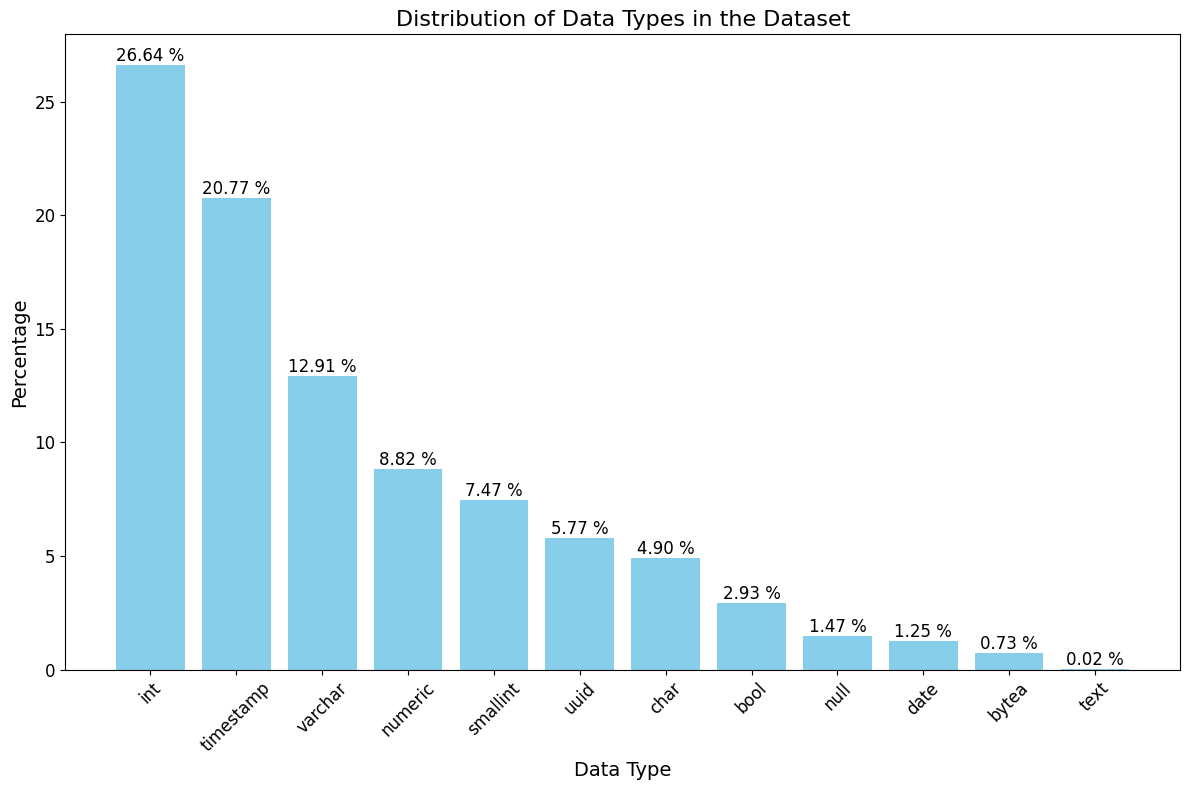

In [3]:
# Import necessary libraries

import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import textwrap

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1

# Step 2: Open the CSV file
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    print("Total rows in CSV: ", total_rows)
    # Skip the header
    next(reader)
    # Iterate over each row in the CSV file
    for i, row in enumerate(reader):
        if i >= end_row:
            break
        if i >= start_row:
            # Append the prompt (first column) to the prompts list
            prompts.append(row[0])
            # Append the response (second column) to the responses list
            responses.append(row[1])

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []


# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)

# Convert DataFrame to string
#MASTER_DF_str = MASTER_DF.head(100).to_string()


# Function to wrap text
def wrap_text(text, width=20):
    return textwrap.fill(text, width=width)

# Apply the text wrapping function to the 'Prompt_Element' column
MASTER_DF['Wrapped_Prompt'] = MASTER_DF['Prompt_Element'].apply(wrap_text)

# Configure pandas display options for better readability
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 1000)

# Display the DataFrame with text wrapping
print(MASTER_DF[['Wrapped_Prompt', 'Key', 'Datatype', 'Constraints']].head(100).to_string(index=False))

# Indent each line
#indented_df_str = textwrap.indent(MASTER_DF_str, '    ')  # 4 spaces of indentation
#print("Master DataFrame: ", indented_df_str)

# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df['percentage'] = (data_type_counts_df['count'] / len(MASTER_DF)) * 100
# Plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df.index.astype(str), data_type_counts_df['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# **10% Sampling of Dataset**

Total rows in input CSV File:  6780
Total Sampled Data:  678
Unique values in the 'Datatype' column:
['int' 'timestamp' 'smallint' 'bool' 'varchar' 'numeric' 'uuid' 'char'
 'bytea' 'date' 'null']

Unique values in the 'Constraints' column:
['PRIMARY KEY' 'null' 'CHECK' 'CHECK, PRIMARY KEY']
Number of occurrences of each datatype:
Datatype
int          1563
timestamp    1140
varchar       674
numeric       518
smallint      363
uuid          311
char          259
bool          148
null           74
date           68
bytea          34
Name: count, dtype: int64

Number of occurrences of each constraint:
Constraints
null                  2839
CHECK                 1208
PRIMARY KEY           1047
CHECK, PRIMARY KEY      58
Name: count, dtype: int64


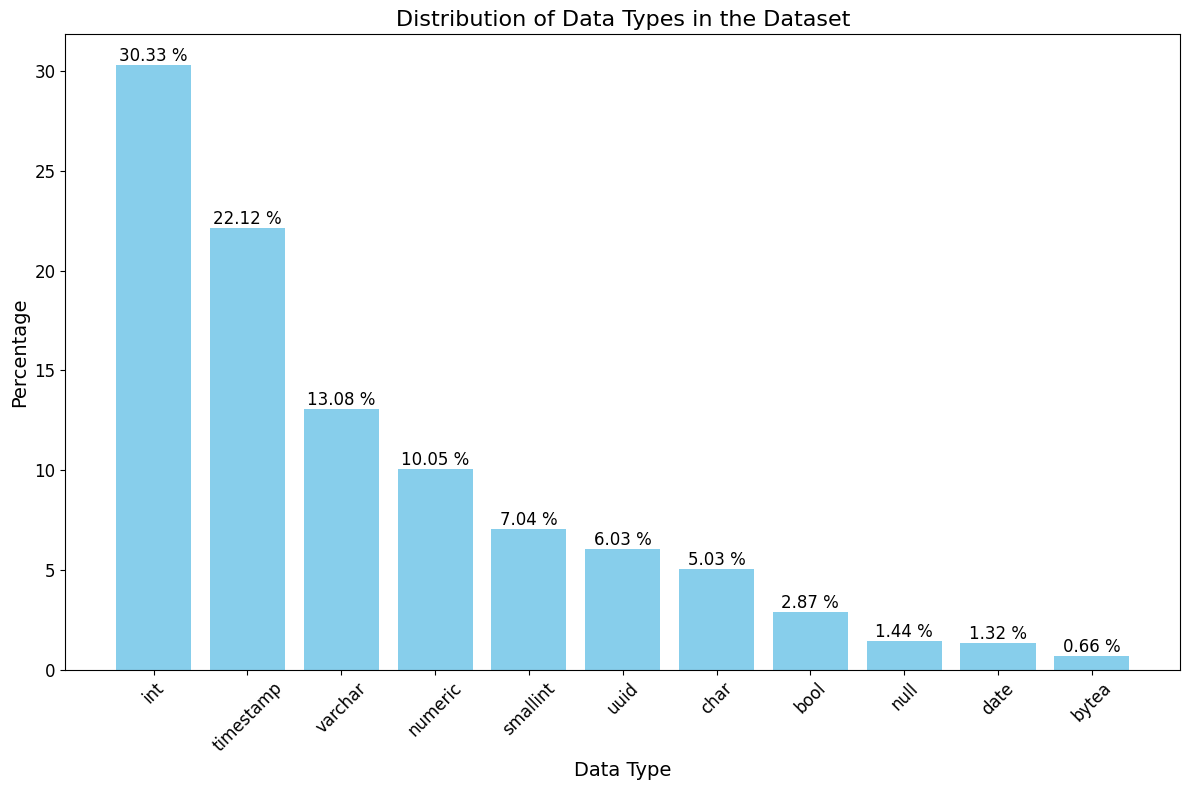

In [4]:
# Import necessary libraries

import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/Colab Notebooks/TrainingData/processed_data_adw_full_shuffledrows.csv"

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1

# Step 2: Open the CSV file
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    print("Total rows in input CSV File: ", total_rows)
    # Skip the header
    next(reader)
    # Iterate over each row in the CSV file
    for i, row in enumerate(reader):
        if i >= end_row:
            break
        if i >= start_row:
            # Append the prompt (first column) to the prompts list
            prompts.append(row[0])
            # Append the response (second column) to the responses list
            responses.append(row[1])

# Combine prompts and responses into a single list for easier sampling
combined_data = list(zip(prompts, responses))

# Sample 50% of the data
sampled_data = random.sample(combined_data, int(len(combined_data) * 0.1))

# Split the sampled data back into prompts and responses
sampled_prompts, sampled_responses = zip(*sampled_data)

# Convert sampled prompts and responses back to lists
sampled_prompts = list(sampled_prompts)
sampled_responses = list(sampled_responses)

# Use the sampled data for further processing
prompts = sampled_prompts
responses = sampled_responses
print("Total Sampled Data: ", len(prompts))

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []


# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF_10 = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)


# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF_10['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF_10['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df10 = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df10['percentage'] = (data_type_counts_df10['count'] / len(MASTER_DF_10)) * 100
# Plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df10.index.astype(str), data_type_counts_df10['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# **50% Sampling of Dataset**

Total rows in input CSV File:  6780
Total Sampled Data:  3390
Unique values in the 'Datatype' column:
['int' 'uuid' 'timestamp' 'bytea' 'varchar' 'char' 'smallint' 'numeric'
 'null' 'bool' 'date' 'text']

Unique values in the 'Constraints' column:
['PRIMARY KEY' 'null' 'CHECK' 'CHECK, PRIMARY KEY' 'UNIQUE']
Number of occurrences of each datatype:
Datatype
int          7617
timestamp    5646
varchar      3334
numeric      2385
smallint     1872
uuid         1501
char         1411
bool          740
null          355
date          318
bytea         168
text            3
Name: count, dtype: int64

Number of occurrences of each constraint:
Constraints
null                  13840
CHECK                  5898
PRIMARY KEY            5339
CHECK, PRIMARY KEY      270
UNIQUE                    3
Name: count, dtype: int64


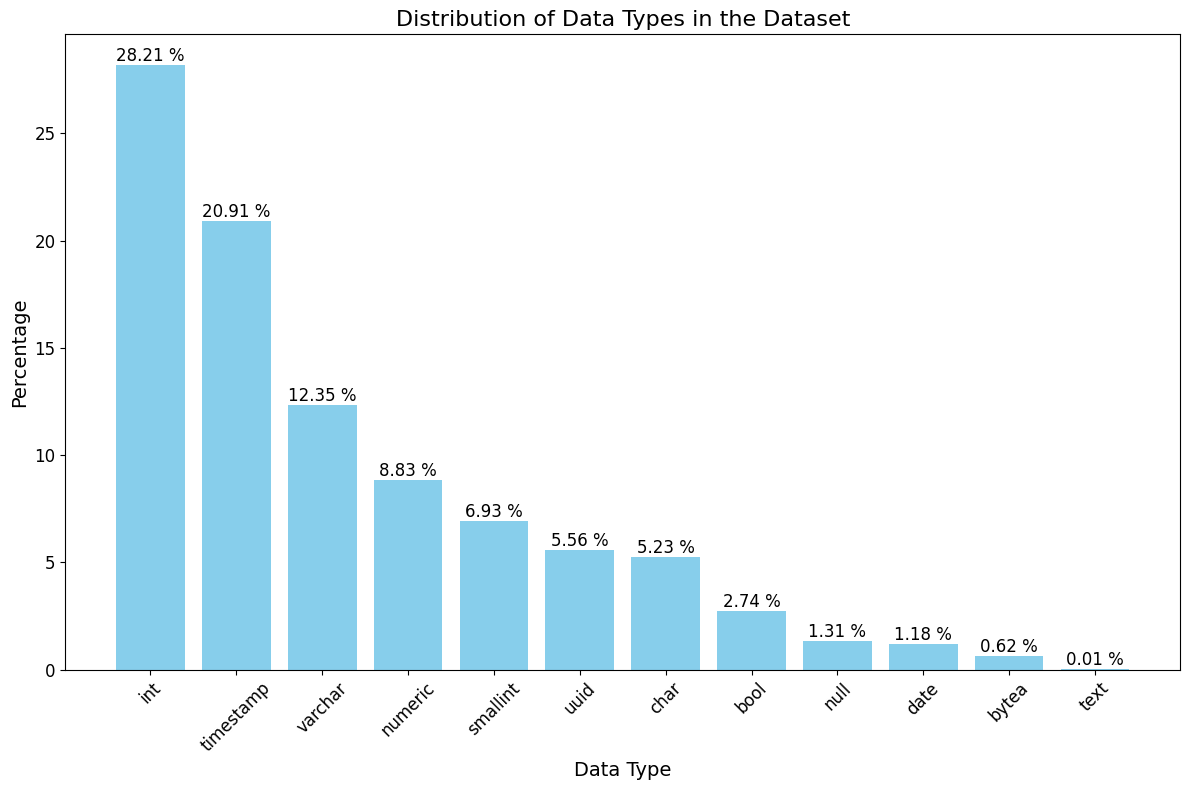

In [15]:
# Import necessary libraries

import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/Colab Notebooks/TrainingData/processed_data_adw_full_shuffledrows.csv"

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1

# Step 2: Open the CSV file
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    print("Total rows in input CSV File: ", total_rows)
    # Skip the header
    next(reader)
    # Iterate over each row in the CSV file
    for i, row in enumerate(reader):
        if i >= end_row:
            break
        if i >= start_row:
            # Append the prompt (first column) to the prompts list
            prompts.append(row[0])
            # Append the response (second column) to the responses list
            responses.append(row[1])

# Combine prompts and responses into a single list for easier sampling
combined_data = list(zip(prompts, responses))

# Sample 50% of the data
sampled_data = random.sample(combined_data, int(len(combined_data) * 0.5))

# Split the sampled data back into prompts and responses
sampled_prompts, sampled_responses = zip(*sampled_data)

# Convert sampled prompts and responses back to lists
sampled_prompts = list(sampled_prompts)
sampled_responses = list(sampled_responses)

# Use the sampled data for further processing
prompts = sampled_prompts
responses = sampled_responses
print("Total Sampled Data: ", len(prompts))

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []


# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF_50 = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)


# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF_50['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF_50['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df50 = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df50['percentage'] = (data_type_counts_df50['count'] / len(MASTER_DF_50)) * 100
# Plot the distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df50.index.astype(str), data_type_counts_df50['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Total rows in input CSV File:  6780
Total Sampled Data:  6780
Unique values in the 'Datatype' column:
['int' 'varchar' 'smallint' 'numeric' 'uuid' 'timestamp' 'null' 'bytea'
 'bool' 'char' 'date' 'text']

Unique values in the 'Constraints' column:
['PRIMARY KEY' 'null' 'CHECK' 'CHECK, PRIMARY KEY' 'UNIQUE']
Number of occurrences of each datatype:
Datatype
int          15324
timestamp    11324
varchar       6660
numeric       4833
smallint      3823
uuid          2991
char          2828
bool          1498
null           754
date           640
bytea          372
text            12
Name: count, dtype: int64

Number of occurrences of each constraint:
Constraints
null                  27864
CHECK                 12066
PRIMARY KEY           10621
CHECK, PRIMARY KEY      496
UNIQUE                   12
Name: count, dtype: int64


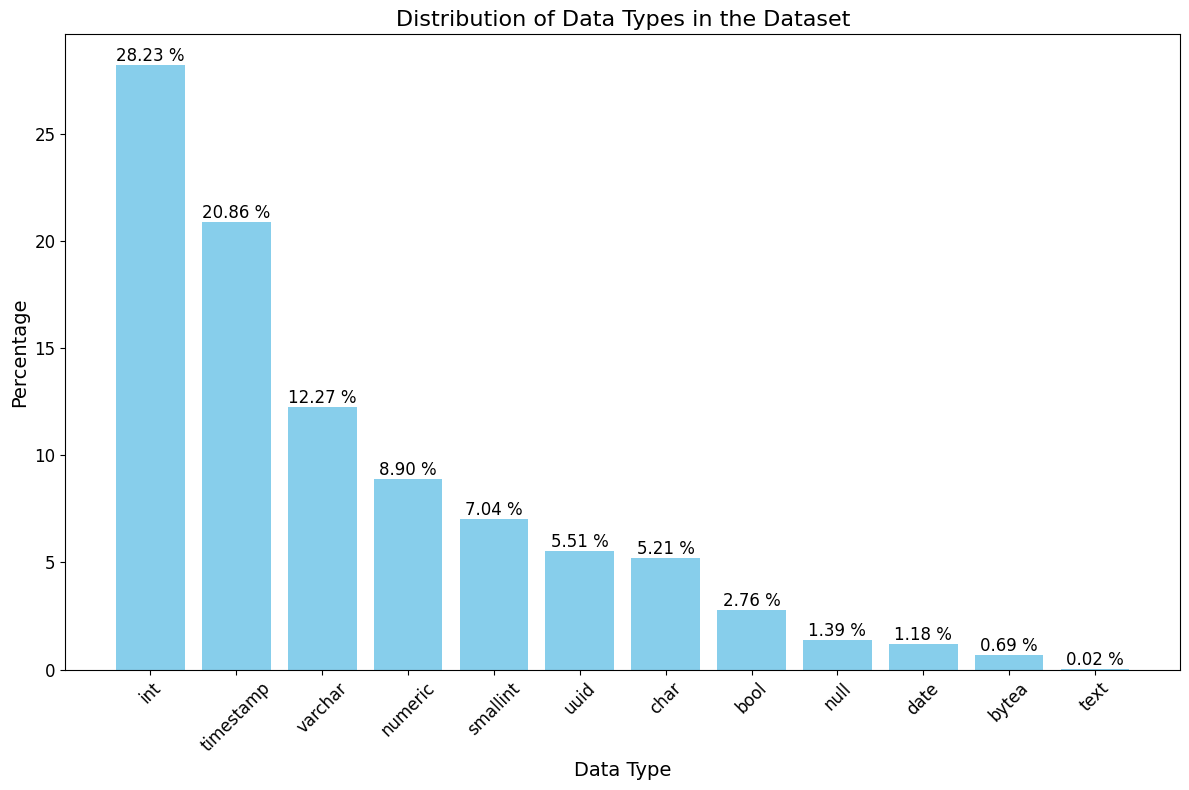

<Figure size 1400x1000 with 0 Axes>

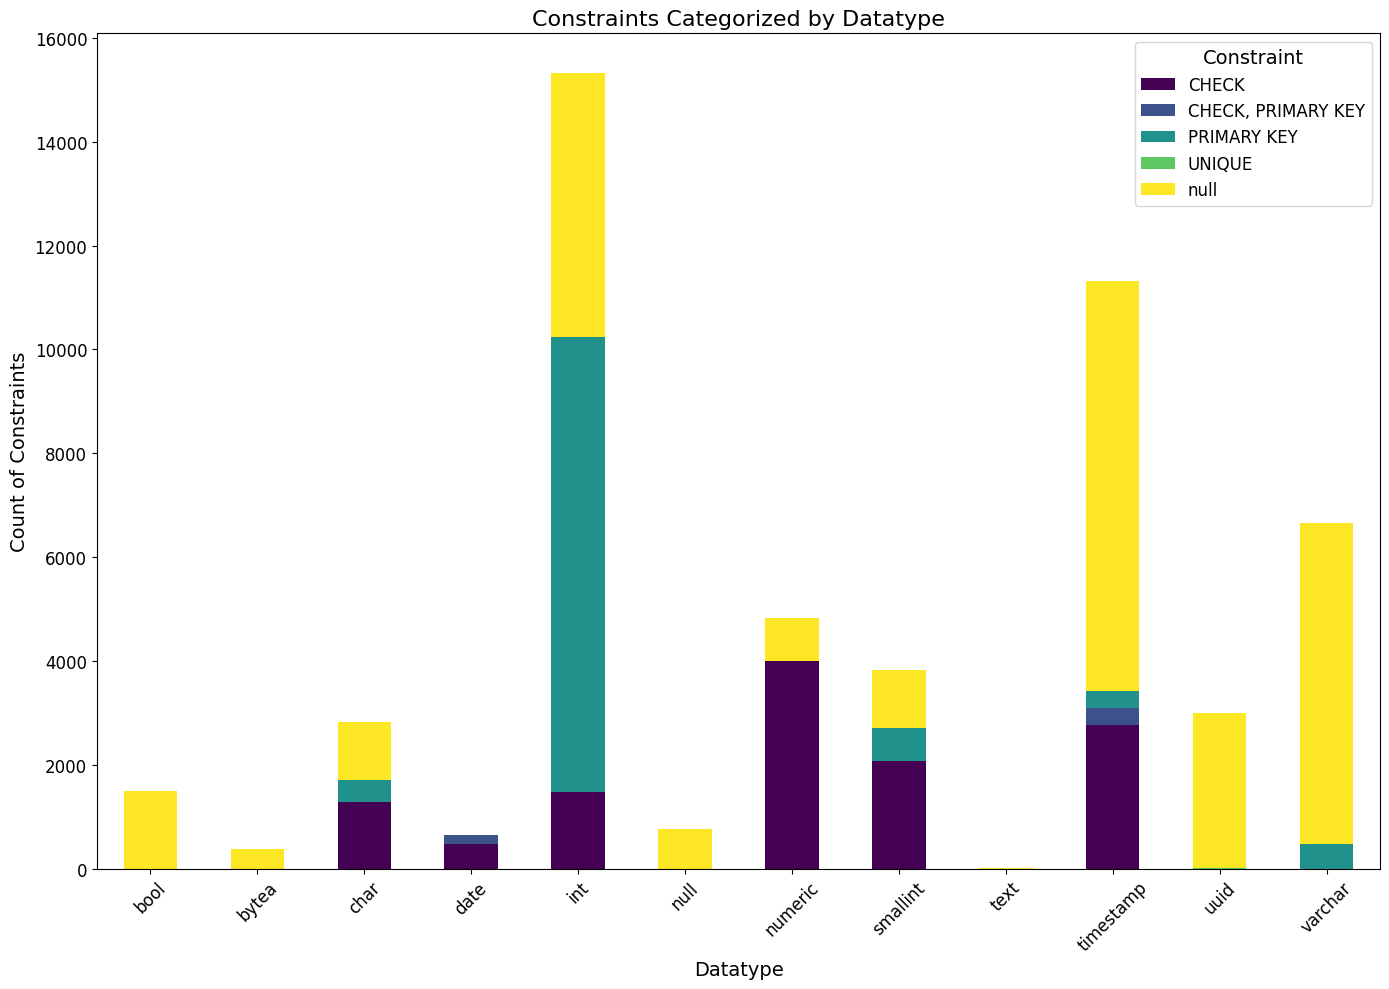

In [13]:
# Import necessary libraries
import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/Colab Notebooks/TrainingData/processed_data_adw_full_shuffledrows.csv"

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header
    header = next(reader)

    # Initialize a counter for total rows
    total_rows = 0

    # First, count the total number of rows
    for _ in reader:
        total_rows += 1

# Step 2: Open the CSV file
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    print("Total rows in input CSV File: ", total_rows)
    # Skip the header
    next(reader)
    # Iterate over each row in the CSV file
    for i, row in enumerate(reader):
        if i >= end_row:
            break
        if i >= start_row:
            # Append the prompt (first column) to the prompts list
            prompts.append(row[0])
            # Append the response (second column) to the responses list
            responses.append(row[1])

# Combine prompts and responses into a single list for easier sampling
combined_data = list(zip(prompts, responses))

# Sample 100% of the data
sampled_data = random.sample(combined_data, int(len(combined_data) * 1))

# Split the sampled data back into prompts and responses
sampled_prompts, sampled_responses = zip(*sampled_data)

# Convert sampled prompts and responses back to lists
sampled_prompts = list(sampled_prompts)
sampled_responses = list(sampled_responses)

# Use the sampled data for further processing
prompts = sampled_prompts
responses = sampled_responses
print("Total Sampled Data: ", len(prompts))

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY',
    'FOREIGN KEY':'FOREIGN KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF_50 = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)

# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF_50['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF_50['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df50 = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df50['percentage'] = (data_type_counts_df50['count'] / len(MASTER_DF_50)) * 100

# Plot the distribution of data types
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df50.index.astype(str), data_type_counts_df50['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Step 6: Additional Plot for Constraints Categorized by Datatype ###
# Create a contingency table for constraints by datatype
constraint_by_datatype = pd.crosstab(MASTER_DF_50['Datatype'], MASTER_DF_50['Constraints'])

# Plot the constraints categorized by datatype
plt.figure(figsize=(14, 10))
constraint_by_datatype.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 10))

# Add title and labels with improved font sizes
plt.title('Constraints Categorized by Datatype', fontsize=16)
plt.xlabel('Datatype', fontsize=14)
plt.ylabel('Count of Constraints', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add legend with improved font size
plt.legend(title='Constraint', fontsize=12, title_fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


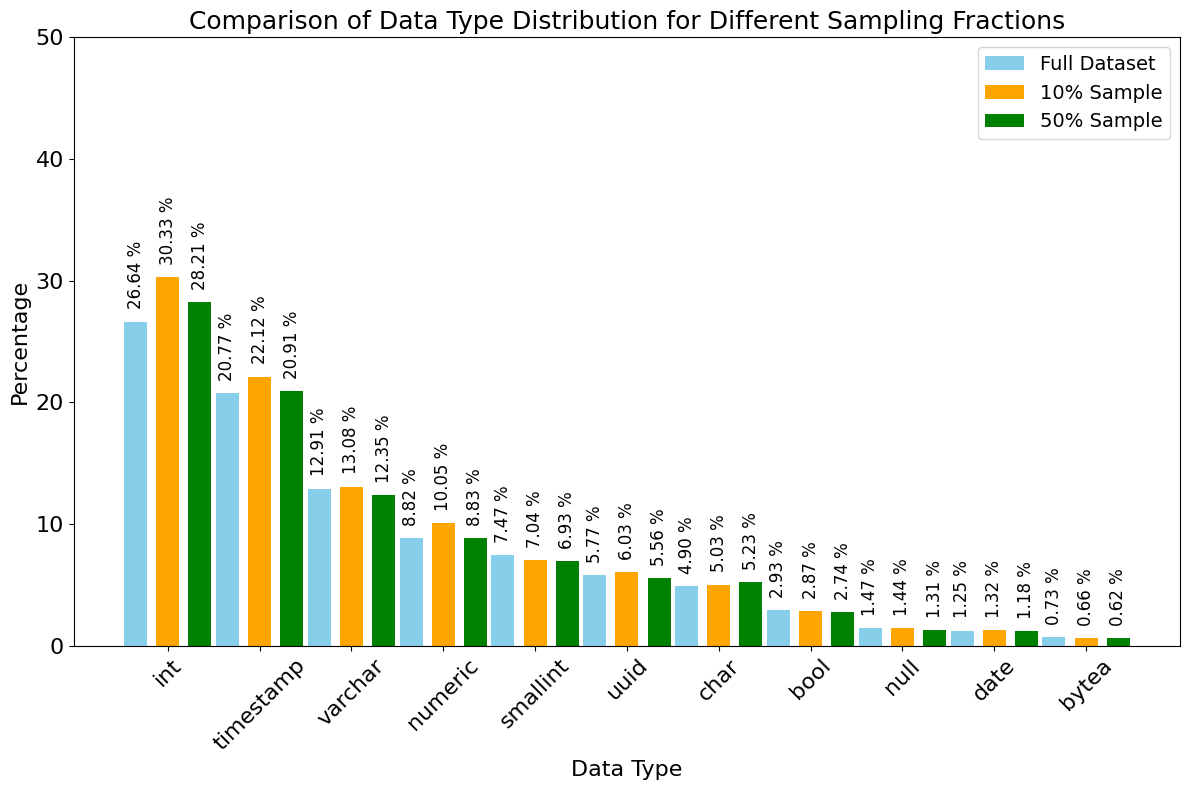

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dataframes are already defined

# Get the common data types present in all dataframes
common_data_types = set(data_type_counts_df.index) & set(data_type_counts_df10.index) & set(data_type_counts_df50.index)

# Filter dataframes to include only common data types
filtered_df = data_type_counts_df[data_type_counts_df.index.isin(common_data_types)]
filtered_df10 = data_type_counts_df10[data_type_counts_df10.index.isin(common_data_types)]
filtered_df50 = data_type_counts_df50[data_type_counts_df50.index.isin(common_data_types)]

# Plot the data from each dataframe on the same axis
plt.figure(figsize=(12, 8))

# Set the positions of the x-ticks
num_bars = len(common_data_types)
index = np.arange(num_bars)

# Set the width of each bar and the space between sets of bars
bar_width = 0.25
bar_space = 0.1

# Plot data from 'filtered_df'
bars1 = plt.bar(index, filtered_df['percentage'], width=bar_width, color='skyblue', label='Full Dataset')

# Plot data from 'filtered_df10'
bars2 = plt.bar(index + bar_width + bar_space, filtered_df10['percentage'], width=bar_width, color='orange', label='10% Sample')

# Plot data from 'filtered_df50'
bars3 = plt.bar(index + 2 * (bar_width + bar_space), filtered_df50['percentage'], width=bar_width, color='green', label='50% Sample')

# Define a function to adjust label position
def adjust_label_position(bar, label):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 1, f'{label:.2f} %', ha='center', va='bottom', fontsize=12, rotation=90)

# Add percentage labels on top of the bars
for bars, df in zip([bars1, bars2, bars3], [filtered_df, filtered_df10, filtered_df50]):
    for bar, label in zip(bars, df['percentage']):
        adjust_label_position(bar, label)

# Add title and labels with improved font sizes
plt.title('Comparison of Data Type Distribution for Different Sampling Fractions', fontsize=18)
plt.xlabel('Data Type', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

# Set y-axis limit
plt.ylim(0, 50)

# Set x-axis ticks and labels
plt.xticks(index + bar_width + bar_space, filtered_df.index, rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()